In [ ]:
# This notebook shows how to use ranking_HM.py to generate objects (rank_objs) collecting
# the background and foreground triggers and then scoring and ranking
# the triggers for getting the false alarm rates (IFARs)

# Just as an example, we show finding of GWC190711 in a particular ~5 hour chunk of O3a data.

# Check the google drive folder for the latest version of this and other notebooks:
# https://drive.google.com/drive/folders/15avuKxY40aX9Ru_6xkacM1ZdaGL7OgQm?usp=sharing

In [1]:
import os, sys
from pathlib import Path
sys.path.insert(0,os.path.join(Path(os.getcwd()).parent, 'Pipeline'))
sys.path.insert(0,"/data/jayw/IAS/GW/gw_detection_ias") # personalize path if needed
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import template_bank_generator_HM as tg
import template_bank_params_O3a_HM as tbp
import matplotlib.pyplot as plt
from importlib import reload
import json, time, params
import scipy
import scipy.stats as stats

import glob, gc, copy
import utils
import multiprocess as mp

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal,lalsimulation
lal.swig_redirect_standard_output_error(False);

In [2]:
# The main python file associated with this notebook is ranking_HM.py
import ranking_HM as rank

import triggers_single_detector_HM as trig
import coincidence_HM as coin

In [3]:
# %matplotlib inline
plt.rcParams["figure.figsize"] = (5, 3)
plt.rcParams["axes.grid"]=True;plt.rcParams["grid.alpha"]=0.4; 
plt.rcParams["grid.color"]='#999999'; plt.rcParams["grid.linestyle"]='--'

In [13]:
run = 'O3a'
# Either use the default search directory
search_dir = utils.SEARCH_OUTPUT_DIR['hm_'+run.lower()]
# or specify the search directory
# search_dir = '/data/jayw/IAS/GW/Data/Testing'

In [14]:
rank_obj_dir = os.path.join(search_dir, 'Ranking')
os.makedirs(rank_obj_dir, exist_ok=True)

print('By default:')
print(f'''Objects of the ranking class will be saved in
{rank_obj_dir}''')

By default:
Objects of the ranking class will be saved in
/Users/jayw/Documents/Acad/GW/Pipeline_data/HM_O3a_search/Ranking


# 1. Making and saving ranking_HM objects

## 1.1 Making and saving ranking_HM objects

In [6]:
# If you want to test the code, first try it for a single bank
bank_id_arr = [7]
# Otherwise use all banks
# bank_id_arr = np.arange(0,tbp.nbanks, dtype=int)

In [7]:
# This cell generates mock rho^\perp_22, rho^\perp_33, rho^\perp_44 values
# corresponding to Gaussian noise triggers above incoherent SNR of 20
# (I denote the SNR by Z)
Z_gauss_complex = np.empty((0,6), dtype=float)
for i in range(100):
    Z_sample = np.random.normal(size=(1000000,6))
    Z_gauss_complex = np.r_[Z_gauss_complex,
             Z_sample[np.linalg.norm(Z_sample, axis=1)**2>20]]
Z_gauss_complex = Z_gauss_complex[:,0::2] + 1j*Z_gauss_complex[:,1::2]
Z_gauss_complex.shape

(277341, 3)

/Users/jayw/Documents/Acad/GW/Public_pipeline/Pipeline/ranking_HM.py:567: RuntimeWarning: divide by zero encountered in log
  rank_corr = 2*np.log(val_marg/val_gauss)
/Users/jayw/Documents/Acad/GW/Public_pipeline/Pipeline/ranking_HM.py:572: RuntimeWarning: divide by zero encountered in divide
  popt, pcov = optimize.curve_fit(parabolic_func, xarr, rank_corr, sigma=10/np.sqrt(val_marg))


a_fit = -0.007811253521695387 rho_0^2 = 49.04700985100601


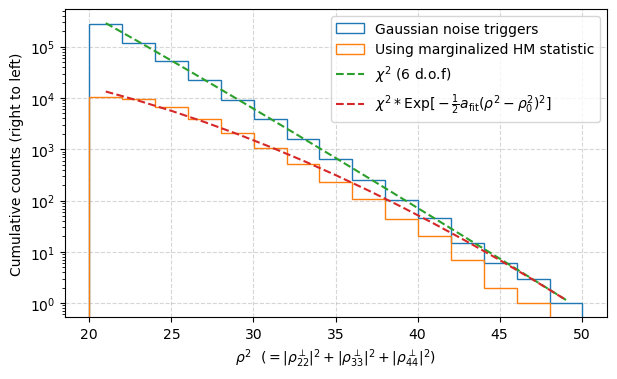

In [8]:
# In this notebook, we want to calculate the non-Gaussian correction
# to the ranking statistic (see arXiv: 2405.17400).
# We therefore want to compare the empirical histogram of the SNR^2
# to that expected from the Gaussian noise hypothesis (see Fig.3 of the paper).
# The empirical histogram is unfortunately also affected by downsampling
# at the low SNR^2 end due to using HM marginalized statistic based threshold
# in the matched_filtering stage (instead of using \rho_incoherent^2 as the threshold).
# To remedy this, we do a quick and rough calculation of the downsampling correction.
# and fit it by a parabolic function to avoid noise at the high SNR^2 end.
# The fit is later used to correct the empirical histogram or rank function
# calculated below

# Showing the plot for the fitted correction for an example bank
a_fit, rhoSQ_0 = rank.generate_downsampling_correction_fits(Z_gauss_complex=Z_gauss_complex,
                         bank_id=(2,0), tbp_dir=tbp.DIR, return_plot=True)
print('a_fit =',a_fit, 'rho_0^2 =',rhoSQ_0)

# Increase the input number of samples if you want to increase the accuracy at high SNR^2

In [ ]:
%%time
# Calculating the downsampling correction coefficients for all subbanks

ncores = 10
subbank_list = [(ib,isb) for ib in bank_id_arr for isb in range(tbp.nsubbanks[f'BBH_{ib}'])]
p = mp.Pool(ncores)
downsampling_fit_coeffs = p.starmap(rank.generate_downsampling_correction_fits,
    ((Z_gauss_complex, subbank, tbp.DIR) for subbank in subbank_list));
p.close()
p.join()
# del Z_gauss_complex # if you want to free up memory

In [16]:
print('By default:')
print(f'''Objects of the ranking class will be saved in
{rank_obj_dir}''')

print(f'''We will use single detector triggers from
{os.path.join(search_dir, 'Triggers_single_det')}
and coincidence candidates from
{os.path.join(search_dir, 'Candidates')}''')

By default:
Objects of the ranking class will be saved in
/Users/jayw/Documents/Acad/GW/Pipeline_data/HM_O3a_search/Ranking
We will use single detector triggers from
/Users/jayw/Documents/Acad/GW/Pipeline_data/HM_O3a_search/Triggers_single_det
and coincidence candidates from
/Users/jayw/Documents/Acad/GW/Pipeline_data/HM_O3a_search/Candidates


In [ ]:
cand_iter = 'cand2' # coincidence iteration to collect
# use the same as in notebook 4. Trig_Coin_on_cluster.ipynb

# We first make the rank objects separately for different banks to avoid memory issues
# by collecting the output files from coincidence

for ib in bank_id_arr:
    n_subbanks = tbp.nsubbanks[f'BBH_{ib}']
    fake_cand_dirs = [[[]]*tbp.nbanks]; fake_output_dirs = [[[]]*tbp.nbanks]
    fake_cand_dirs[0][ib] = [os.path.join(
        search_dir, 'Candidates', f'BBH_{ib}_bank_{j}{cand_iter}') for j in range(n_subbanks)]
    fake_output_dirs[0][ib] = [os.path.join(
        search_dir, 'Triggers_single_det', f'BBH_{ib}_bank_{j}') for j in range(n_subbanks)]
    rank_obj = rank.Rank(chirp_mass_id=ib, 
                           cver=cand_iter, runs=[run],collect_before_veto=True,
                    collect_timeseries=False, snr2min_marg=None, coinc_ftype='npz',
                    cs_ver='JR', cand_dirs_all=fake_cand_dirs,
                    outputdirs_all=fake_output_dirs)

    rank_obj.downsampling_corr_fit_params = \
                    [downsampling_fit_coeffs[subbank_list.index((ib,isb))]
                             for isb in range(n_subbanks)]
    rank_obj.to_hdf5(os.path.join(rank_obj_dir, f"BBH_{ib}.hdf5"), overwrite=True)
    gc.collect()
    
# If there is memory accumulation, you can restart the kernel after the files are saved
# and then continue with the next cell

In [ ]:
%%time
rank_objs = []
for i in bank_id_arr:
    rank_objs.append(
        rank.Rank.from_hdf5(os.path.join(rank_obj_dir, f"BBH_{i}.hdf5"), mode='r+'))
    gc.collect()

In [ ]:
# Maximizing the triggers over banks
# Note that even if you are just testing the code with a single bank, you still need to run this cell

# Note that this cell needs ~100GB of RAM when used on the full observing run data (with all banks)

# We list two particular veto flags which are supposed to be overridden
# we will make this by default in a future version of the code
vetos_to_override = ['Louder trigger within the 0.01 s bucket',
                     'Coincident SNR']

mask_veto_criteria = rank_objs[0].mask_veto_criteria.copy()
override_inds = [np.where(
    rank_objs[0].veto_metadata_keys==veto)[0][0] for veto in vetos_to_override]
mask_veto_criteria[override_inds] *= False
rank.maximize_over_banks(rank_objs, downsampling_correction=True,
                mask_veto_criteria=mask_veto_criteria,
                maxopts_filepath=os.path.join(rank_obj_dir, "BBH_maxopts.hdf5"))

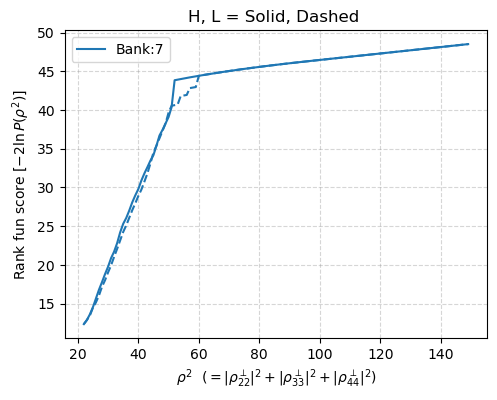

In [20]:
# Visually inspecting the rank functions
# They should roughly look like a power law (at low SNR)
# with a knee appearing when the non-Gaussian noise starts to dominate
# (we already used the downsampling_corr_fit_params to correct for the low SNR end)

isb = 0

plt.figure(figsize=(12, 4))

ind = 0
if len(bank_id_arr)>1:
    plt.subplot(121)
    for ib in bank_id_arr[:len(bank_id_arr)//2]:
        input_arr = np.arange(rank_objs[ind].snr2min,150)
        plt.plot(input_arr, rank_objs[ind].score_funcs[isb][0](input_arr), color=f'C{ind}',label=f'Bank:{ib}')
        plt.plot(input_arr, rank_objs[ind].score_funcs[isb][1](input_arr), color=f'C{ind}', ls='--')
        ind+=1
    plt.title('H, L = Solid, Dashed '); plt.legend();
    plt.xlabel(r'$\rho^2\ \ (=|\rho^\perp_{22}|^2+|\rho^\perp_{33}|^2+|\rho^\perp_{44}|^2)$');
    plt.ylabel(r'Rank fun score [$-2 \ln P(\rho^2)$]');


plt.subplot(122)
for i, ib in enumerate(bank_id_arr[len(bank_id_arr)//2:]):
    input_arr = np.arange(rank_objs[ind].snr2min,150)
    plt.plot(input_arr, rank_objs[ind].score_funcs[isb][0](input_arr), color=f'C{ind}',label=f'Bank:{ib}')
    plt.plot(input_arr, rank_objs[ind].score_funcs[isb][1](input_arr), color=f'C{ind}', ls='--')
    ind+=1
plt.title('H, L = Solid, Dashed '); plt.legend();
plt.xlabel(r'$\rho^2\ \ (=|\rho^\perp_{22}|^2+|\rho^\perp_{33}|^2+|\rho^\perp_{44}|^2)$');
plt.ylabel(r'Rank fun score [$-2 \ln P(\rho^2)$]');

In [21]:
# Saving the final set of rank functions

for i, ind in enumerate(bank_id_arr):
    rank_objs[i].to_hdf5(path=os.path.join(rank_obj_dir, f"BBH_{ind}.hdf5"),
                          overwrite=True)
    rank_objs[i] = []
    gc.collect()

## 1.2 Understanding the saved objects

In [ ]:
# This section is not essential, just to understand the rank objs

In [22]:
%%time
# Loading the saved banksbg objects
bank_id_arr = [7] # individual banks
# bank_id_arr = np.arange(0,tbp.nbanks, dtype=int)

rank_objs=[]
for i in bank_id_arr:
    rank_objs.append(rank.Rank.from_hdf5(
        os.path.join(rank_obj_dir, f"BBH_{i}.hdf5"), mode='r'))

Couldn't access / properly, falling back to base group
CPU times: user 3.95 s, sys: 3.27 s, total: 7.22 s
Wall time: 7.44 s


In [23]:
# Pick a particular bank index
rank_obj = rank_objs[0]

In [24]:
# Showing the list of the candidates in the bank
# IFAR is computed within the particular bank and per observing run

rank_obj.compute_fars_coherent_score()

# If you're running the default settings in this code,
# the IFAR=inf candidate at tgps=1246849694.634 is GWC190711_030756

# To find further info about this (or any other) candidate,
# use the code in section 3. Inspecting interesting candidates



Rank New final score and IFAR 
IFAR is per bank per run time (or per time-chunk passed)

Zero-lag candidates:
ind: 0, Rank: 0, IFAR: inf, H1_time: 1246849694.634, SNR^2: (31.51, 68.35)
ind: 1, Rank: 188, IFAR: 10.64, H1_time: 1246845141.938, SNR^2: (28.9, 36.33)

LSC events:

Injections:


/Users/jayw/Documents/Acad/GW/Public_pipeline/Pipeline/ranking_HM.py:3848: RuntimeWarning: divide by zero encountered in scalar divide
  f'IFAR: {round(self.Nsim / cand_rank_full[ind], 2)}, ' +


(array([  0, 188]), array([], dtype=int64), array([], dtype=int64))

In [25]:
full_scores_cand = rank_obj.coherent_scores_cand + rank_obj.cand_0_score + rank_obj.cand_1_score
full_scores_lsc = rank_obj.coherent_scores_lsc + rank_obj.lsc_0_score + rank_obj.lsc_1_score
full_scores_bg = np.nan_to_num(rank_obj.coherent_scores_bg + rank_obj.back_0_score + rank_obj.back_1_score)

# Limiting the lower range of the background candidates scores
full_scores_bg[full_scores_bg<-200] = -200*np.ones_like(full_scores_bg[full_scores_bg<-200])

Number of time-slides we used for the background:
2000.0


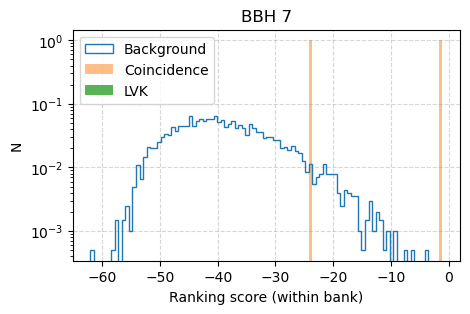

In [26]:
print(f'''Number of time-slides we used for the background:
{rank_obj.Nsim}''')

_,bins= np.histogram(np.r_[full_scores_bg,full_scores_cand,full_scores_lsc], bins=100)
plt.hist(full_scores_bg, bins=bins, weights=np.ones_like(full_scores_bg)/rank_obj.Nsim,
          label='Background', histtype='step')
plt.hist(full_scores_cand, log=True, bins=bins, label='Coincidence',alpha=0.5);
plt.hist(full_scores_lsc, log=True, bins=bins, label='LVK',alpha=0.8);
plt.xlabel(r'Ranking score (within bank)'); plt.ylabel('N');
# plt.ylim(bottom=0.2); 
# plt.xlim(left=-100)
plt.legend(); 
plt.title(f'BBH {ib}');

# We divied the bkg histogram by Nsim, as we expect 
# Nsim bkg due to noise for every 1 coincidence candidate due to noise

In [27]:
# rank_obj also contains a list of candidates
# both before and after maximization over subbanks and banks.

# Candidates before maximization are given by e.g.,
rank_obj.bg_fg_by_subbank[1][(7,1)]

[<EditableHDF5Dataset "events": shape (3, 2, 15), type "<f8">,
 <EditableHDF5Dataset "veto_metadata": shape (3, 2, 48), type "|b1">,
 <EditableHDF5Dataset "prior_terms": shape (3, 4), type "<f8">]

In [28]:
# Here are the keys to understand the bg_fg_by_subbank candidate data
rank_obj.bg_fg_by_subbank_keys

{'Description': 'List containing candidates before maximization over subbanks (and banks)',
 'ind_0': {0: 'Background (timeslides)',
  1: 'Coincidence (non-LVK)',
  2: 'Coincidence (LVK)',
  3: 'Injections'},
 'ind_1': '(bank_id, subbank_id)',
 'ind_2': {0: 'n_cand x n_det x processedclist',
  1: 'n_cand x n_det x veto_metadata',
  2: {'n_cand x n_det x': {0: 'Coherent score',
    1: '-rho^2',
    2: '2 log(1/median normfac^3)',
    3: '2 log(template prior)'}}}}

In [29]:
# The keys of the processedclist are given by
rank_obj.example_trigs[0].processedclist_keys

{'Description': 'processedclist stores properties of collected triggers in the following format',
 0: 'time',
 1: 'incoherent_SNRsq',
 2: 'normfac_22',
 3: 'hole_correction_22',
 6: 'psd_drift_correction',
 7: 'Re(SNR_22)',
 8: 'Im(SNR_22)',
 9: 'Re(SNR_33)',
 10: 'Im(SNR_33)',
 13: 'calpha_0'}

In [30]:
# After maximization over subbanks and banks and after the veto tests are done,
#  the candidates are given in e.g.,
print(rank_obj.cands_postveto_max[1][1])

[HDF5DatasetSubset([ -0.71777699, -65.22357257,   1.65550923,  -3.22166491]), HDF5DatasetSubset([[ 1.24684514e+09,  2.88954837e+01,  7.57446423e-01,
                     1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
                     9.84765887e-01,  1.99540942e-01,  4.63688334e+00,
                     1.70735715e+00,  1.97519245e+00, -2.58627729e-01,
                     6.86759091e-01, -4.55025715e-01,  0.00000000e+00],
                   [ 1.24684514e+09,  3.63280888e+01,  9.74809185e-01,
                     1.00000000e+00,  1.00000000e+00,  9.99379002e-01,
                     9.58591580e-01, -4.40127191e+00, -2.54917787e+00,
                     9.49730396e-01,  2.06082338e+00,  2.08243465e+00,
                     9.86443960e-01, -4.55025715e-01,  0.00000000e+00]]), (7, 1), HDF5DatasetSubset([[ 1.24684514e+09,  1.99540942e-01,  4.63688334e+00,
                     7.69163953e-01],
                   [ 1.24684514e+09, -4.40127191e+00, -2.54917787e+00,
                    

In [31]:
# Here are the keys to understand the cands_postveto_max_keys candidates
rank_obj.cands_postveto_max_keys

{'Description': 'List containing both vetoed and non-vetoed candidates after maximization over banks',
 'ind_0': {0: 'Background (timeslides)',
  1: 'Coincidence (non-LVK)',
  2: 'Coincidence (LVK)',
  3: 'Injections'},
 'ind_1': 'candidate_index',
 'ind_2': {0: {0: 'Coherent score',
   1: '-rho^2',
   2: '2 log(1/median normfac^3)',
   3: '2 log(template prior)'},
  1: {0: 'H_trigger_processedclist', 1: 'L_trigger_processedclist'},
  2: {'bank_id', 'subbank_id'},
  3: {0: {'H': 't',
    1: 'Re(rho_22)',
    2: 'Im(rho_22)',
    3: 'Det. sensitivity (Normfac/ASD drift*hole correction)'},
   1: 'L'},
  4: {0: 'Veto_metadata_H', 1: 'Veto_metadata_L'},
  5: 'Index into bg_by_subbank'}}

In [32]:
# Similar to cands_postveto_max_keys, cands_preveto_max_keys contain the maximized candidates
# but before the filtering due to veto tests is done, e.g.,
print(rank_obj.cands_preveto_max[1][1])

[HDF5DatasetSubset([ 13.62768582, -79.19734175,   1.65550923, -13.60936546]), HDF5DatasetSubset([[ 1.24684440e+09,  4.82767472e+01,  7.57446423e-01,
                     9.97307930e-01,  9.99457195e-01,  9.97235292e-01,
                     9.96717870e-01,  3.36886013e+00, -1.77424518e+00,
                    -3.05710736e+00,  3.97191228e+00,  2.03788417e+00,
                    -2.12240859e+00,  1.46213030e+00, -3.23364471e-01],
                   [ 1.24684440e+09,  3.09205945e+01,  9.74809185e-01,
                     1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
                     9.62304294e-01,  2.80655930e+00,  4.23542941e+00,
                    -2.13703403e+00, -2.49213476e-01,  6.80641623e-01,
                     1.12527008e-01,  1.46213030e+00, -3.23364471e-01]]), (7, 1), HDF5DatasetSubset([[ 1.24684440e+09,  3.36886013e+00, -1.77424518e+00,
                     7.57894833e-01],
                   [ 1.24684440e+09,  2.80655930e+00,  4.23542941e+00,
                    

## Extras

In [ ]:
# Please ignore this section for now

### Rerunning vetos for top-ranked triggers below min_veto_chi2

In [ ]:
# As the veto tests are costly, they are only performed on the high SNR candidates.
# Sometimes however, low SNR candidates are near the top of the list as defined by our ranking statistic.
# We therefore use the veto_subthreshold_top_cands function in ranking_HM.py to apply the veto tests
# to such top subthreshold candidates.

# This function needs to be run separately. Below is a code which can be copy-pasted to a python file

import os, sys
sys.path.insert(0,"/data/jayw/IAS/GW/gw_detection_ias") # CHANGE path
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

import numpy as np
import ranking_HM as rank
import utils

run = 'O3b'
search_dir = utils.SEARCH_OUTPUT_DIR['hm_'+run.lower()]
triggers_dir = os.path.join(search_dir,'Triggers_single_det')
ncores = 23
num_redo_bkg = 5000

for ib in range(int(sys.argv[1]), int(sys.argv[2])):
    print(f'Running {run} HM Bank {ib}')

    rank_obj = rank.Rank.from_hdf5(
        os.path.join(search_dir,'Ranking',f'BBH_{ib}.hdf5'), mode='r+')

    rank.veto_subthreshold_top_cands(rank_obj, 
                                     triggers_dir=triggers_dir, ncores=ncores,
                                    num_redo_bkg=num_redo_bkg)

    print('Saving the banks')
    rank_obj.to_hdf5(os.path.join(search_dir,'Ranking',f'BBH_{ib}.hdf5'), overwrite=True)

In [ ]:
#!/bin/bash

#SBATCH --job-name=Extra_vetos
#SBATCH --time=20:00:00
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=1
#SBATCH --cpus-per-task=24
#SBATCH --mem-per-cpu=4GB
#SBATCH --output=/data/jayw/IAS/GW/Trash/Slurm_out/%j.out
#SBATCH --error=/data/jayw/IAS/GW/Trash/Slurm_out/%j.err
#SBATCH --mail-type=FAIL #END, FAIL, ALL
#SBATCH --mail-user=jayw@ias.edu

python /home/jayw/IAS/GW/Scripts/Extra_vetos.py $1 $(($1 + 1))

# for i in {0..17}
# do
#    sbatch submit.sh $i
# done

### Rank func per template group

In [ ]:
# Remove this sub-section later

In [151]:
vetoed=True
rank_funcs_groups=[]
bkbg.back_0_score=[]; bkbg.back_1_score=[]
bkbg.back_0_score_vetoed=[]; bkbg.back_1_score_vetoed=[]
bkbg.score_funcs =[]
for i in range(len(bkbg.scores_bg_by_subbank)):
    rank_funcs_groups.append(bkbg.rank_scores_calc_MZ(i, downsampling_correction=True, output_rank_func_temp_grps=True,
                                                  matching_point=None, vetoed=vetoed))
if vetoed:
    bkbg.back_0_score = np.concatenate(bkbg.back_0_score_vetoed)
    bkbg.back_1_score = np.concatenate(bkbg.back_1_score_vetoed)
else:
    bkbg.back_0_score = np.concatenate(bkbg.back_0_score)
    bkbg.back_1_score = np.concatenate(bkbg.back_1_score)

snr2_ref for subbank 0 is 64.37
and the safety lower limit of glitch fraction for templates is 0.05
Split the templates into 13 groups for calculating the rank functions.


Text(0, 0.5, '$\\tilde{\\rho}^2$')

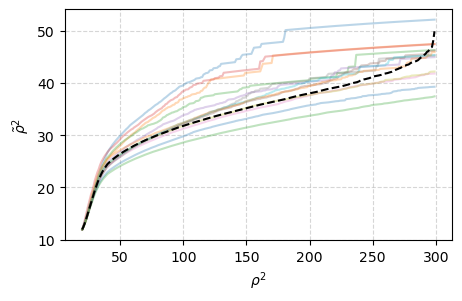

In [155]:
isb=0; det=1
input_arr = np.arange(bkbg.snr2min,300)
for func in rank_funcs_groups[isb]:
    plt.plot(input_arr, func[det](input_arr),alpha=0.3)
plt.plot(input_arr, bkbg.score_funcs[isb][det](input_arr), color='k', ls='--')
plt.xlabel(r'$\rho^2$'); plt.ylabel(r'$\tilde{\rho}^2$')

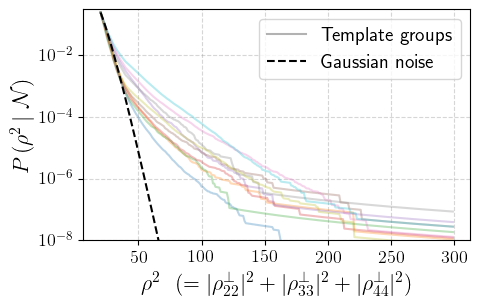

In [ ]:
isb=0; det=1
input_arr = np.arange(bkbg.snr2min,300)
full_subbank_prob = np.exp(-bkbg.score_funcs[isb][det](input_arr)/2)
norm = np.sum(full_subbank_prob)
chi2_scaling = full_subbank_prob[0]/norm
for func in rank_funcs_groups[isb]:
    plt.semilogy(input_arr, np.exp(-func[det](input_arr)/2)/norm,alpha=0.3)
plt.semilogy([50,100],[1e-20, 1e-20], alpha=0.3, color='k', label='Template groups')
plt.semilogy(input_arr, stats.chi2.pdf(input_arr,12)/stats.chi2.pdf(input_arr[0],12)*chi2_scaling,
              color='k', ls='--', label='Gaussian noise')
# plt.semilogy(input_arr, np.exp(-bkbg.score_funcs[isb][det](input_arr)/2)/norm, color='k', ls='--')
plt.xlabel(r'$\rho^2\ \ (=|\rho^\perp_{22}|^2+|\rho^\perp_{33}|^2+|\rho^\perp_{44}|^2)$');
plt.ylabel(r'$P\, (\rho^2\, |\ \mathcal{N})$')
plt.legend(fontsize=14)
plt.ylim(bottom=1e-8, top=3e-1);
# plt.savefig('/data/jayw/CCA/Plots/trash.pdf', bbox_inches='tight')

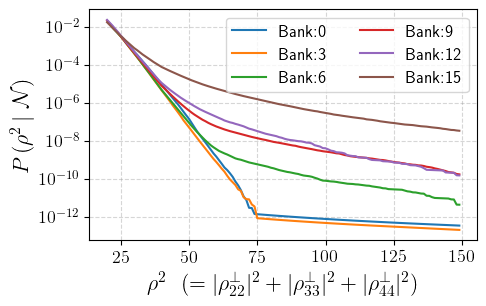

In [ ]:
for ib in range(0,17,3):
    input_arr = np.arange(banksbg[ib].snr2min,150)
    plt.semilogy(input_arr, np.exp(-banksbg[ib].score_funcs[0][0](input_arr)/2),label=f'Bank:{ib}')
plt.legend(fontsize=12,loc=1, ncol=2);
plt.xlabel(r'$\rho^2\ \ (=|\rho^\perp_{22}|^2+|\rho^\perp_{33}|^2+|\rho^\perp_{44}|^2)$');
plt.ylabel(r'$P\, (\rho^2\, |\ \mathcal{N})$');
# plt.savefig('/data/jayw/CCA/Plots/trash.pdf', bbox_inches='tight')

# 2. Making candidate list and comparing to LVK catalog

In [ ]:
# Once you have saved the final rank_objs for all banks,
# you can use this section to make separate catalog
# overlapping and non-overlapping with the LVK events

In [ ]:
%%time
# Loading the saved banksbg objects
# Warning: takes about 15 mins to load all banks

# bank_id_arr = [8]
bank_id_arr = np.arange(0,tbp.nbanks, dtype=int)

rank_objs=[]
for i in bank_id_arr:
    rank_objs.append(rank.Rank.from_hdf5(
        os.path.join(rank_obj_dir, f"BBH_{i}.hdf5")))

In [33]:
import warnings, io, copy, pickle
import pandas as pd

In [35]:
# Loading the cumulative astrophysical prior in each bank.
# we use the file saved during the template prior generation (in 2.Astrophysical_prior.ipynb)

weights_banks = np.load(os.path.join(tbp.template_prior_DIR,
    'samples_info_1.0e+07.npz'),
                        allow_pickle=True)['p_banks']
weights_banks = np.array([np.sum(weights_banks[ib]) for ib in range(17)])

In [9]:
# The ranking scores are calculated for each bank separately.
# For making a global IFAR accross all banks, we need to shift the bank scores
# so that the IFAR = 1/(cumulative_bank_probability)
# For example, if we have two banks with prob ratios 10:1,
# we expect 10 candidates from the first bank for every candidate from the second.
# Essentially, this step corrects for non-Gaussian over-production of triggers,
# especially in the high mass banks.

banks_bg_masks = []
banks_cand_masks = []
banks_lsc_masks = []
banks_shifted_scores_bg = []
banks_shifted_scores_fg = []
banks_shifted_scores_lsc = []
banks_shift_score = []

for ib in range(0,tbp.nbanks):
    fullscoresbg = rank_objs[ib].coherent_scores_bg + rank_objs[ib].back_0_score + rank_objs[ib].back_1_score
    banks_bg_masks.append((np.isnan(fullscoresbg) == False) & np.isfinite(fullscoresbg))
    fullscoresbg = fullscoresbg[banks_bg_masks[-1]]
    
    fullscorescand = rank_objs[ib].coherent_scores_cand + rank_objs[ib].cand_0_score + rank_objs[ib].cand_1_score
    banks_cand_masks.append((np.isnan(fullscorescand) == False) & np.isfinite(fullscorescand))
    fullscorescand = fullscorescand[banks_cand_masks[-1]]
    
    fullscoreslsc = rank_objs[ib].coherent_scores_lsc + rank_objs[ib].lsc_0_score + rank_objs[ib].lsc_1_score
    banks_lsc_masks.append((np.isnan(fullscoreslsc) == False) & np.isfinite(fullscoreslsc))
    fullscoreslsc = fullscoreslsc[banks_lsc_masks[-1]]
    
    fullscoresfg = np.concatenate([fullscorescand, fullscoreslsc])
    bgsorted = np.sort(fullscoresbg)[::-1]
    fgsorted = np.sort(fullscoresfg)[::-1]
    ind_shift = int(2000 * weights_banks[ib] - 1) # This corresponds to each bank being combined at IFAR = 1/weights_banks[ib]
    # ind_shift = 2000 - 1 # This corresponds to each bank being combined at IFAR=1
    
    score_shift = bgsorted[ind_shift]
    banks_shift_score.append(score_shift)
    fullscoresfg -= score_shift
    fullscoresbg -= score_shift
    fullscoreslsc -= score_shift
    banks_shifted_scores_bg.append(fullscoresbg.copy())
    banks_shifted_scores_fg.append(fullscoresfg.copy())
    banks_shifted_scores_lsc.append(fullscoreslsc.copy())
    
banks_fg_masks = [np.concatenate([msk0, msk1])
                  for msk0, msk1 in zip(banks_cand_masks, banks_lsc_masks)]
allbanksbg_shifted = np.sort(np.concatenate(banks_shifted_scores_bg))
allbanksfg_shifted = np.sort(np.concatenate(banks_shifted_scores_fg))

######## ADD RANK SCORE INFORMATION
for ib, rank_obj in enumerate(rank_objs):
    rank_obj.rank_scores_bg = rank_obj.coherent_scores_bg + rank_obj.back_0_score + rank_obj.back_1_score
    rank_obj.rank_scores_cand = rank_obj.coherent_scores_cand + rank_obj.cand_0_score + rank_obj.cand_1_score
    rank_obj.rank_scores_lsc = rank_obj.coherent_scores_lsc + rank_obj.lsc_0_score + rank_obj.lsc_1_score
    rank_obj.rank_scores_bg_shifted = rank_obj.rank_scores_bg - banks_shift_score[ib]
    rank_obj.rank_scores_cand_shifted = rank_obj.rank_scores_cand - banks_shift_score[ib]
    rank_obj.rank_scores_lsc_shifted = rank_obj.rank_scores_lsc - banks_shift_score[ib]

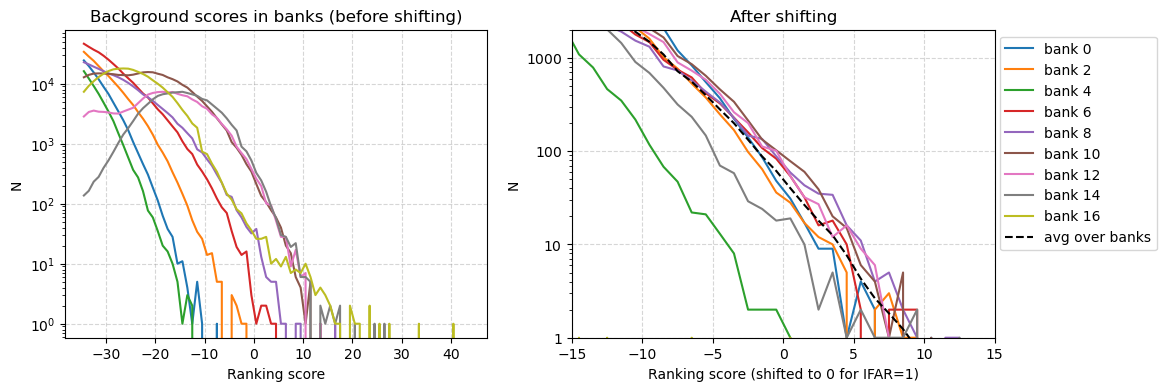

In [10]:
LOWER_lim, UPPER_lim= (-35, 45)
bins=np.arange(LOWER_lim, UPPER_lim,1)
bincenters = (bins[1:]+bins[:-1])/2
plt.figure(figsize=(12,4))
plt.subplot(121)
for ib in range(0,17,2):
    val, *_ = np.histogram(
        rank_objs[ib].rank_scores_bg[rank_objs[ib].rank_scores_bg>LOWER_lim],bins=bins);
    plt.semilogy(bincenters,val,label=f'bank {ib}')
    plt.title('Background scores in banks (before shifting)');
plt.xlabel('Ranking score'); plt.ylabel('N'); 
plt.subplot(122)
for ib in range(0,17,2):
    val, *_ = np.histogram(
        rank_objs[ib].rank_scores_bg_shifted[rank_objs[ib].rank_scores_bg_shifted>LOWER_lim],bins=bins);
    plt.semilogy(bincenters,val,label=f'bank {ib}')
val, *_ = np.histogram(allbanksbg_shifted[allbanksbg_shifted>LOWER_lim],bins=bins);
plt.semilogy(bincenters,val/17,color='k',ls='--', label='avg over banks')
plt.xlim(left=-15, right=15)
plt.ylim(top=2e3,bottom=1e0); 
plt.legend(loc=1,bbox_to_anchor=(1.4, 1.0))
plt.xlabel('Ranking score (shifted to 0 for IFAR=1)'); plt.ylabel('N'); 
plt.title('After shifting');

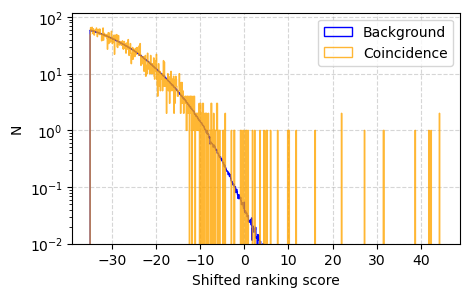

In [11]:
histtype='step'
bins=np.arange(LOWER_lim, UPPER_lim,.1)
bg_hist=plt.hist(allbanksbg_shifted[allbanksbg_shifted>LOWER_lim], bins=bins, label='Background', color='blue',
                     density=False, weights=np.ones_like(allbanksbg_shifted[allbanksbg_shifted>LOWER_lim])/2000, cumulative=False,
                     histtype=histtype, log=True)
fg_hist=plt.hist(allbanksfg_shifted[allbanksfg_shifted>LOWER_lim], bins=bins, label='Coincidence', color='orange', density=False,
                     cumulative=False, alpha=.8, histtype=histtype, log=True)
plt.legend();
plt.ylim(bottom=1e-2)
plt.xlabel('Shifted ranking score'); plt.ylabel('N');

In [12]:
# Saving just the final ranking scores to calculate the p_astro
# in the next notebook
fname_hist_arrs = os.path.join(rank_obj_dir,
                     f'{run}_scores_by_bank.json')

with open(fname_hist_arrs, 'w') as jsonfile:
    json.dump({'banks_shifted_scores_bg': banks_shifted_scores_bg,
               'banks_shifted_scores_fg': banks_shifted_scores_fg,
               'banks_shift_score': banks_shift_score,
                }, jsonfile, cls=utils.NumpyEncoder, indent=2)
!chmod 755 {fname_hist_arrs}

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
#### GET ALL CANDIDATE INFO
if run == 'O3a':
    runs_per_yr = 106 / 365.
elif run == 'O3b':
    runs_per_yr = 96.28 / 365.
IFAR_THRESHOLD_SAVE = 0.01 # per year, for saving in the candidates dictionary
IFAR_THRESHOLD_PRINT = 0.4 # per year, for printing as output of this cell
print('-'*36+f'\n\t Best coincident cands in {run} not overlapping with LVK\n'+'-'*36)

cands_dict_by_bank = rank.print_top_cand_list(
                        rank_objs, allbanksbg_shifted, runs_per_yr, run,
                        LVK=False, IFAR_THRESHOLD_SAVE=IFAR_THRESHOLD_SAVE,
                        IFAR_THRESHOLD_PRINT=IFAR_THRESHOLD_PRINT)

cands_by_evname = {evn: cdic for bank_cdics in cands_dict_by_bank for evn, cdic in bank_cdics.items()}
ias_cands_by_evname = {k.replace('GWC', 'GW') : v for k, v in cands_by_evname.items()}
ias_cand_evnames = list(ias_cands_by_evname.keys())
ias_cand_evnames.sort()

------------------------------------
	 Best coincident cands in O3b not overlapping with LVK
------------------------------------
------------------------------------------------------------------------ 
BBH_0 by rank:

------------------------------------------------------------------------ 
BBH_1 by rank:

[rank 223] GWC191213_204950 (tgps = 1260305408.129) from bank (1, 2):
 IFAR/yr [bank, global] = 2.37, 0.10
 SNR^2[H,L] = [27.17, 55.19],  SNR^2_modes = [24.7 + 0.6 + 1.9, 41.6 + 7.5 + 6.2]
 Template: ['m1 = 27.17', 'm2 = 25.07', 's1z = 0.52', 's2z = 0.86', 'mchirp = 22.72', 'chieff = 0.68'] 


------------------------------------------------------------------------ 
BBH_2 by rank:

------------------------------------------------------------------------ 
BBH_3 by rank:

------------------------------------------------------------------------ 
BBH_4 by rank:

------------------------------------------------------------------------ 
BBH_5 by rank:

-----------------------------------

------------------------------------ 
	 GWC190605_025957 
  ************************************
IFAR/yr=7.352176174787584
------------------------------------ 
	 GWC190425_133124 
  ************************************
IFAR/yr=5.140016971754151
------------------------------------ 
	 GWC190521_075726 
  ************************************
IFAR/yr=3.4165995165189362


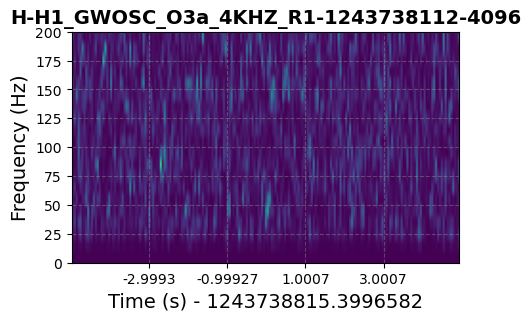

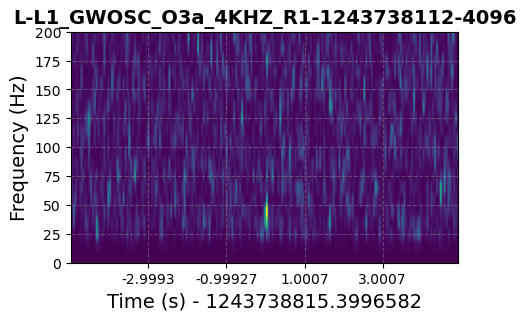

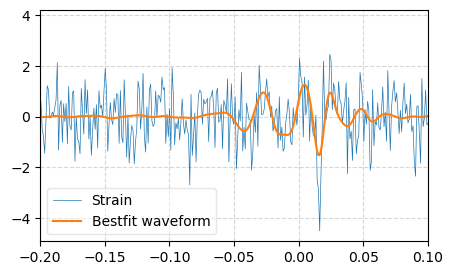

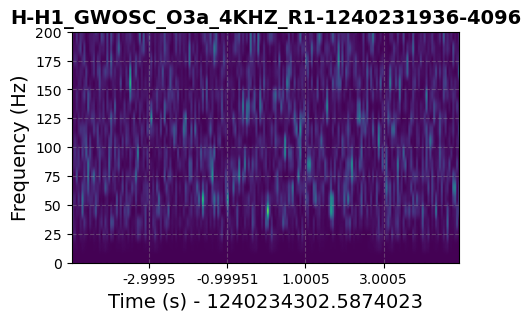

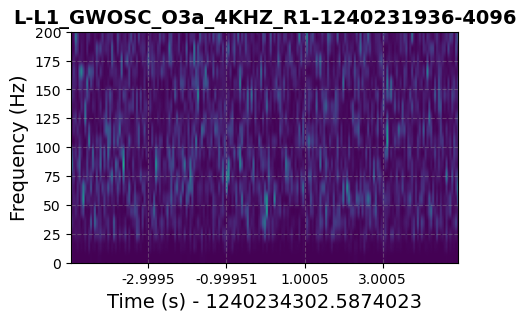

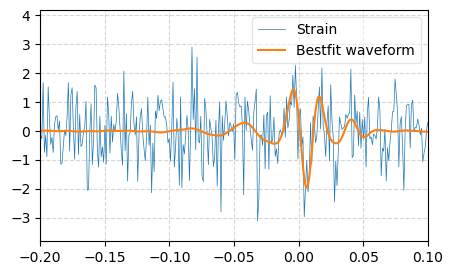

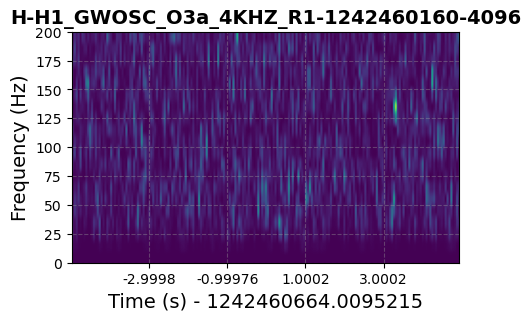

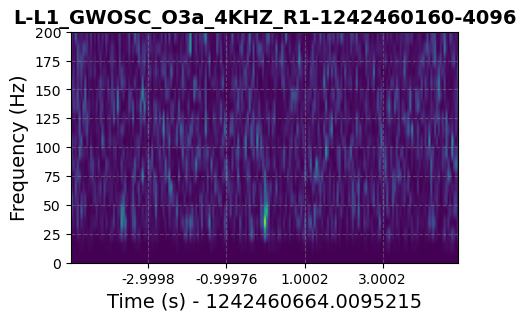

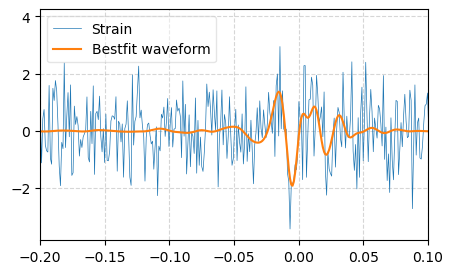

In [15]:
# For checking specgrams and best-fit waveforms of candidates in a particular bank (ib)

ib=14
fmax = 200
t_specgram= 5
nfft = 100
t_bestfit_wf_plot = 0.2
for evn, candic in cands_dict_by_bank[ib].items():
    if candic['ifar_years'] > IFAR_THRESHOLD_PRINT:    
        print('-'*36, '\n\t', evn, '\n  '+'*'*36)
        tg_H, tg_L = [trig.TriggerList.from_json(config_fname=fnm)
                        for fnm in candic['fnames'][:2]]
        print(f"IFAR/yr={candic['ifar_years']}")
        tg_H.specgram(t0=candic['tgps'], tmin=-t_specgram, tmax=t_specgram, nfft=nfft, noverlap=nfft//2)
        plt.ylim(top=fmax)
        tg_L.specgram(t0=candic['tgps'], tmin=-t_specgram, tmax=t_specgram, nfft=nfft, noverlap=nfft//2)
        plt.ylim(top=fmax)
        if candic['i_refdet'] == 0:
            ax = tg_H.plot_bestfit_waveform(candic['trigger'][0])
            ax.set_xlim(-t_bestfit_wf_plot,0.1)
        elif candic['i_refdet'] == 1:
            ax = tg_L.plot_bestfit_waveform(candic['trigger'][1])
            ax.set_xlim(-t_bestfit_wf_plot,0.1)
        else:
            raise Exception('Something wrong with irefdet!')
        # print('\n\n'+'-'*72+'\n\n')

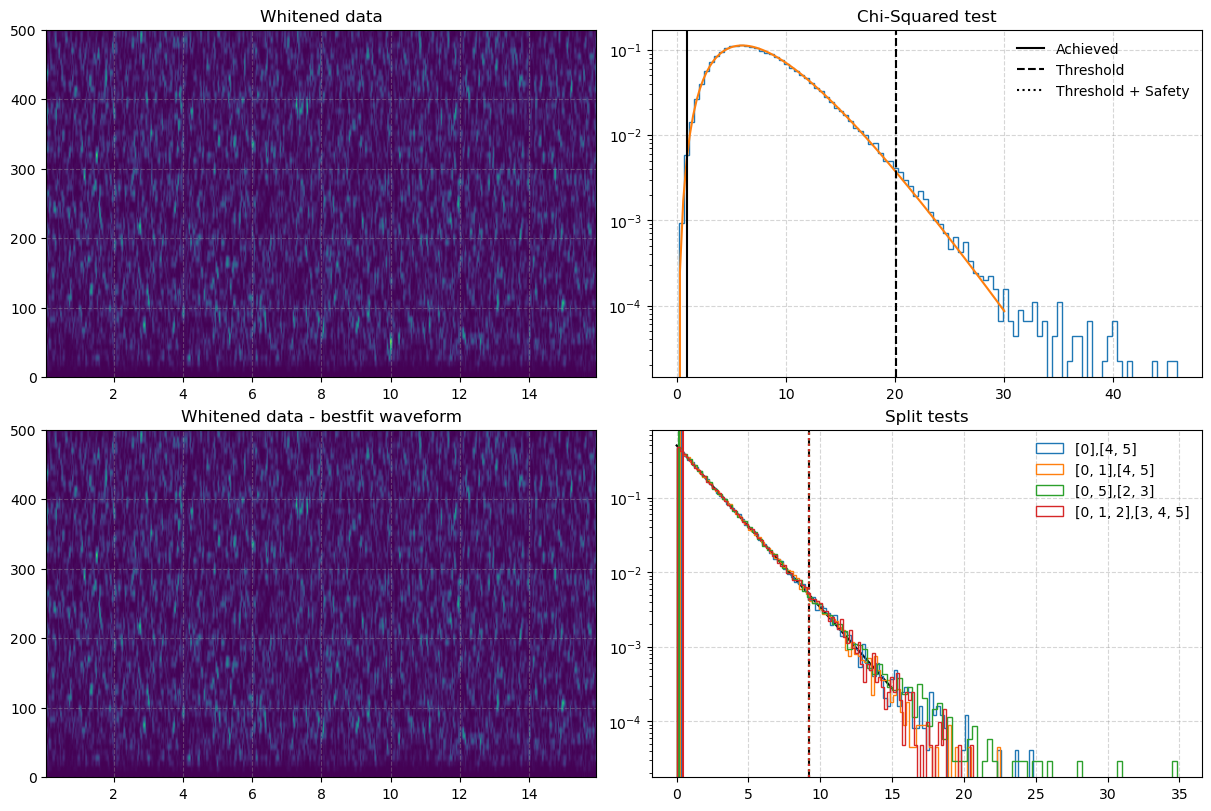

In [45]:
# For checking veto test results for particular candidates
# The solid lines should be lower than the dotted ones on the right panels,
# otherwise the candidate is vetoed
# Note that the candidate is at t=10s on the x-axis in the left-panels by design

candic = cands_dict_by_bank[ib]['GWC190425_133124']
det_ind = candic['i_refdet']
trigObj = trig.TriggerList.from_json(
    config_fname=candic['fnames'][det_ind])
# signal_enhancement_factor is used for giving the 
# data - signal_enhancement_factor * best-fit waveform
# in the bottom panel
# signal_enhancement_factor=10 artificially enhances the
# best-fit waveform to make it obvious in the plot
# (use signal_enhancement_factor=1 for normal view)
utils.plot_veto_details(trigObj, candic['trigger'][det_ind], 
                        signal_enhancement_factor=10, fmax=500,
                        use_HM=True);

In [ ]:
# To further inspect the interesting candidates,
# go to section 3 of the notebook

In [17]:
# Let us now do the same as the cell above but
# candidates overlapping with the LVK event times
print('-'*72+f'\n\t LVK events found in ({run})\n'+'-'*72)

cands_dict_by_bank_lvk = rank.print_top_cand_list(
                        rank_objs, allbanksbg_shifted, runs_per_yr, run,
                        LVK=True, IFAR_THRESHOLD_SAVE=0,
                        IFAR_THRESHOLD_PRINT=0)

cands_by_evname = {evn: cdic for bank_cdics in cands_dict_by_bank_lvk
                      for evn, cdic in bank_cdics.items()}
ias_lvc_evnames = list(cands_by_evname.keys())
ias_lvc_evnames.sort()
ias_lvc_cands_by_evname =  {k.replace('GWC', 'GW') : v for k, v in cands_by_evname.items()}

------------------------------------------------------------------------
	 LVK events found in (O3b)
------------------------------------------------------------------------
------------------------------------------------------------------------ 
BBH_0 by rank:

[rank 0] GW191129_134029 (tgps = 1259070047.138) from bank (0, 3):
 IFAR/yr [bank, global] = inf, inf
 SNR^2[H,L] = [79.71, 102.00],  SNR^2_modes = [72.2 + 1.3 + 6.2, 99.3 + 2.1 + 0.6]
 Template: ['m1 = 13.22', 'm2 = 7.29', 's1z = 0.41', 's2z = -0.70', 'mchirp = 8.47', 'chieff = 0.02'] 


[rank 0] GW191204_171526 (tgps = 1259514944.043) from bank (0, 3):
 IFAR/yr [bank, global] = inf, inf
 SNR^2[H,L] = [97.67, 190.81],  SNR^2_modes = [97.0 + 0.4 + 0.2, 189.1 + 0.9 + 0.8]
 Template: ['m1 = 13.26', 'm2 = 9.49', 's1z = -0.02', 's2z = 0.49', 'mchirp = 9.74', 'chieff = 0.19'] 


[rank 0] GW191105_143521 (tgps = 1256999739.886) from bank (0, 3):
 IFAR/yr [bank, global] = inf, 43.96
 SNR^2[H,L] = [34.67, 63.05],  SNR^2_modes = [32.8 

In [ ]:
# To further inspect the interesting/missed LVC events,
# go to section 3 of the notebook

### Checking IAS, OGC, LVC overlap and saving candidate files

In [ ]:
# This sub-section is currently not documented very well
# it saves the candidate info required for p-astro
# and printing the catalog in latex code in the next notebook
# 6.p_astro+Detection_tables.ipynb

In [20]:
import o3b_catalog_tables as tables

In [15]:
# is this needed

# import pop_inference.gw_pe_bookkeeping as gw_pe_bookkeeping
# bookkeeping = gw_pe_bookkeeping.bookkeeping

## PRINTING
# for evn in ias_cand_evnames:
#     evnm = evn.replace('GWC', 'GW')
#     if evnm in gw_pe_bookkeeping.LVC_O3a_evnames:
#         print(f'LVC+IAS: {evn} (' + ('added in 2.1' if evnm in gw_pe_bookkeeping.LVC_O3a_extra
#                                      else ('found by Nitz+2.1' if gw_pe_bookkeeping.nitz_O3a_extra
#                                            else 'should be in LVC list?')) + ')')
#     elif ((evnm[:8] in gw_pe_bookkeeping.LVC_O3a_evnames) and
#           (utils.get_evname_from_tgps(bookkeeping[evnm[:8]][0]) == evnm)):
#         print(f'LVC+IAS: {evn} ({evnm[:8]})')
#     elif evnm[:-1] in [k[:-1] for k in gw_pe_bookkeeping.LVC_O3a_evnames_marginal]:
#         print('near marginal LVC:', evn)
#     else:
#         print('IAS only:', evn)

In [16]:
# is this needed
## PRINTING
# for evn in ias_lvc_evnames:
#     evnm = evn.replace('GWC', 'GW')
#     if evnm in gw_pe_bookkeeping.LVC_O3b_evnames:
#         print(evn)
#     elif ((evnm[:8] in gw_pe_bookkeeping.LVC_O3b_evnames) and
#           (utils.get_evname_from_tgps(bookkeeping[evnm[:8]][0]) == evnm)):
#         print(evn, f'({evnm[:8]})')
#     elif evnm[:-1] in [k[:-1] for k in gw_pe_bookkeeping.LVC_O3b_evnames_marginal]:
#         tdif = np.min(int(evnm[-6:]) - np.array([int(k[-6:]) for k in
#                                                  gw_pe_bookkeeping.LVC_O3b_evnames_marginal]))
#         print(f'near marginal LVC: {evn} (t0 separation = {tdif} s)')
#     else:
#         print('not in GWTC-2.1:', evn)

In [21]:
## GROUP ALL
all_cands = copy.deepcopy(ias_cands_by_evname)
for k, v in ias_lvc_cands_by_evname.items():
    if k in all_cands:
        print('WARNING:', k, 'is in both LVC and IAS dicts')
        all_cands[k + '_LVC'] = v
    else:
        all_cands[k] = v

for k in all_cands:
    all_cands[k]['evname'] = k
    if run=='O3a':
        all_cands[k]['lvc_found'] = tables.is_lvc(k)
        all_cands[k]['ogc_found'] = tables.is_ogc_o3a(k)
    elif run=='O3b':
        all_cands[k]['lvc_found'] = tables.is_lvc_o3b(k)
        all_cands[k]['ogc_found'] = tables.is_ogc_o3b(k)
    
all_ias_evnames = list(all_cands.keys())
all_ias_evnames.sort()

In [22]:
# Verifying that all the ias_cand_evnames do not overlap with LVK
# and the ias_lvc_evnames do overlap with LVK

if run=='O3a':
    print(len(tables.get_lvc_overlap(ias_cand_evnames)), len(ias_lvc_cands_by_evname),
    len(tables.get_lvc_overlap(ias_lvc_evnames)))
elif run=='O3b':
    print(len(tables.get_lvc_overlap_o3b(ias_cand_evnames)), len(ias_lvc_cands_by_evname),
    len(tables.get_lvc_overlap_o3b(ias_lvc_evnames)))

0 28 28


In [23]:
# Check fname_cands and write to file

fname_cands = os.path.join(search_dir, f'{run}_cands_by_evname.json')

with open(fname_cands, 'w') as jsonfile:
    json.dump(all_cands, jsonfile, cls=utils.NumpyEncoder, indent=2)
!chmod 755 {fname_cands}

# 3. Inspecting interesting candidates

In [ ]:
# This section is for checking the veto status of a 
# candidate at a particular tgps

In [7]:
# File which stored data from our catalog tables 
# (can skip loading it if tgps of candidate is known)
# import o3b_catalog_tables as tables

In [36]:
tgps = 1246849694.628418 # corresponding to GWC190711_030756
# tgps = cands_dict_by_bank[ib]['GWC191202_225602']['tgps']
# tgps = tables.all_ias_cands_HM['GW'+'200114_020818']['tgps']

cand_type = 1
# the allowed values for cand_type are: 
# {0: 'Background (timeslides)',
#   1: 'Coincidence (non-LVK)',
#   2: 'Coincidence (LVK)',
#   3: 'Injections'}

In [24]:
# tgps = tables.lvc_events_dict['GW190701_203306']['tgps']
# cand_type=2

In [38]:
# Checking triggers <1 sec from candidate before maximization over subbanks and banks

print(r'Bankid, rho^2, evidence, rho_22^2, t_diff, veto_test_result, ind_list')
for rank_obj in rank_objs:
    for subbank_id, evnlist in rank_obj.bg_fg_by_subbank[cand_type].items():
        if len(evnlist[0])==0: continue
        imin = np.argmin(np.abs(tgps-evnlist[0][:,0,0]))
        if np.abs(tgps-evnlist[0][imin,0,0])<1:
            print(subbank_id,
                np.sum(evnlist[0][imin,:,1]),
                sum(evnlist[2][imin])+np.sum(evnlist[0][imin,:,1]),
                np.sum(evnlist[0][imin,:,7:9]**2),
                np.abs(tgps-evnlist[0][imin,0,0]),
                np.all(evnlist[1][imin,:,rank_obj.mask_veto_criteria]),
                  imin)
# rank_objs[15].bg_fg_by_subbank[2][(15,0)][0][1]

Bankid, rho^2, evidence, rho_22^2, t_diff, veto_test_result, ind_list
(7, 0) 87.16153397641375 25.861512190899937 72.4964103605692 0.002685546875 True 0
(7, 1) 99.85872168517402 35.57578718895566 78.04839224296629 0.005126953125 True 2


In [39]:
# Checking triggers < 1 sec from candidate after maximization over banks
# both before and after filtering due to veto tests

print(r'Bankid, t_diff, ind_list, rho_22^2 [H,L], rho_33^2 [H,L], rho_44^2')
flag = False
for rank_obj in rank_objs:
    tdiff = np.array([np.abs(tgps-x[1][0,0]) for x in rank_obj.cands_preveto_max[cand_type]])
    if len(tdiff)>0:
        imin = np.argmin(tdiff)
        if (tdiff[imin]<1):
            pclists = rank_obj.cands_preveto_max[cand_type][imin][1].copy()
            pclists = np.round(pclists,2)
            print(rank_obj.cands_preveto_max[cand_type][imin][2], tdiff[imin], imin,
                  pclists[:,7]**2+pclists[:,8]**2, pclists[:,9]**2+pclists[:,10]**2,
                    pclists[:,11]**2+pclists[:,12]**2, '{before veto}')
            # print(rank_obj.cands_preveto_max[cand_type][imin][2], tdiff[imin], imin,
            #       np.round(pclists[:,1],2).astype('str'), '{before veto}')
        
    tdiff_postveto = np.array([np.abs(tgps-x[1][0,0]) for x in rank_obj.cands_postveto_max[cand_type]])
    if len(tdiff_postveto)>0:
        imin = np.argmin(tdiff_postveto)
        if (tdiff_postveto[imin]<1):
            flag = True
            pclists = rank_obj.cands_postveto_max[cand_type][imin][1].copy()
            pclists = np.round(pclists,2)
            print(rank_obj.cands_postveto_max[cand_type][imin][2], tdiff_postveto[imin], imin,
                pclists[:,7]**2+pclists[:,8]**2, pclists[:,9]**2+pclists[:,10]**2,
                    pclists[:,11]**2+pclists[:,12]**2, '{survived veto}')
if not flag:
    print('failed veto')

Bankid, t_diff, ind_list, rho_22^2 [H,L], rho_33^2 [H,L], rho_44^2
(7, 1) 0.005126953125 0 [18.0666 59.8882] [6.073  5.5332] [7.3714 2.8225] {before veto}
(7, 1) 0.005126953125 0 [18.0666 59.8882] [6.073  5.5332] [7.3714 2.8225] {survived veto}


In [47]:
# Select the proper rank_obj and ind_list from above
ind_bank = 0
ind_preveto_max_list = 0
rank_obj = rank_objs[ind_bank]

In [48]:
rank_entry = copy.deepcopy(
    rank_obj.cands_preveto_max[cand_type][ind_preveto_max_list])
print(rank_entry)
print('\n Vetos failed: H, L')
print([rank_obj.veto_metadata_keys[~x] for x in rank_entry[-2]])

[array([ 37.21955621, -99.85872169,   1.65550923,  -3.29927826]), array([[ 1.24684969e+09,  3.15119971e+01,  7.48542594e-01,
         9.77399353e-01,  9.83899387e-01,  9.88540832e-01,
         9.65867221e-01,  1.28558455e+00, -4.05409491e+00,
         2.42911242e+00, -4.06603894e-01, -1.16948733e+00,
         2.44744142e+00, -5.88395321e-01,  0.00000000e+00],
       [ 1.24684969e+09,  6.83467246e+01,  9.67823867e-01,
         1.00000000e+00,  1.00000000e+00,  9.99382014e-01,
         9.81690288e-01,  1.51340720e+00,  7.59404884e+00,
        -1.86408104e+00,  1.44061535e+00, -1.68418093e+00,
        -1.04567571e-02, -5.88395321e-01,  0.00000000e+00]]), (7, 1), array([[ 1.24684969e+09,  1.28558455e+00, -4.05409491e+00,
         7.57479942e-01],
       [ 1.24684969e+09,  1.51340720e+00,  7.59404884e+00,
         9.85874954e-01]]), array([[ True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  Tr

In [49]:
# For reference, here are the keys of the object we probed above
rank_obj.cands_preveto_max_keys

{'Description': 'List containing both vetoed and non-vetoed candidates after maximization over banks',
 'ind_0': {0: 'Background (timeslides)',
  1: 'Coincidence (non-LVK)',
  2: 'Coincidence (LVK)',
  3: 'Injections'},
 'ind_1': 'candidate_index',
 'ind_2': {0: {0: 'Coherent score',
   1: '-rho^2',
   2: '2 log(1/median normfac^3)',
   3: '2 log(template prior)'},
  1: {0: 'H_trigger_processedclist', 1: 'L_trigger_processedclist'},
  2: {'bank_id', 'subbank_id'},
  3: {0: {'H': 't',
    1: 'Re(rho_22)',
    2: 'Im(rho_22)',
    3: 'Det. sensitivity (Normfac/ASD drift*hole correction)'},
   1: 'L'},
  4: {0: 'Veto_metadata_H', 1: 'Veto_metadata_L'},
  5: 'Index into bg_by_subbank'}}

In [50]:
# Checking by redoing the veto and obtaining the trigger objects

cs_instance = rank_obj.create_coh_score_instance()

veto_metadata, coh_score, trig_obj_H, trig_obj_L, trig_H, trig_L, veto_spacings \
    = rank.veto_rank_entry(
        rank_entry,
          ind_preveto_max_list,
            cs_instance=cs_instance,
            rerun_coh_score=True, return_trig_obj_info=True)

veto_metadata[1], coh_score

Creating coherent score instance(s)
Coh score frac complete: 0.0


(array([ True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True]),
 37.20776357591177)

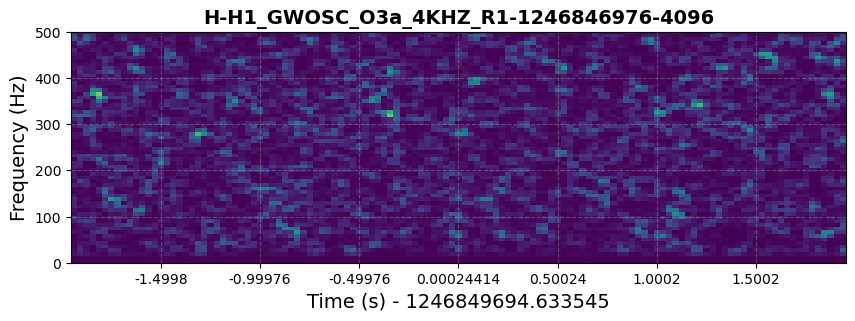

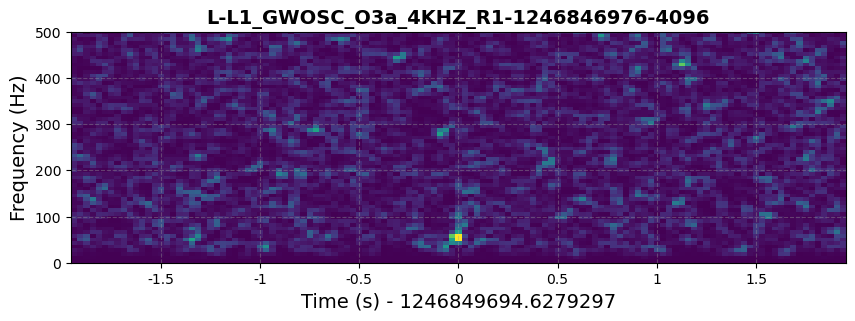

In [52]:
# Checking specgram
plot_time = 2; nfft = 128; noverlap = 96; top_freq=500
fig, ax = plt.subplots(figsize=(10,3))
trig_obj_H.specgram(t0=trig_H[0], tmin = -plot_time, tmax=plot_time, nfft=nfft, noverlap=noverlap, ax=ax)
ax.set_ylim(top=top_freq);
fig, ax = plt.subplots(figsize=(10,3))
trig_obj_L.specgram(t0=trig_L[0], tmin = -plot_time, tmax=plot_time, nfft=nfft, noverlap=noverlap, ax=ax)
ax.set_ylim(top=top_freq);

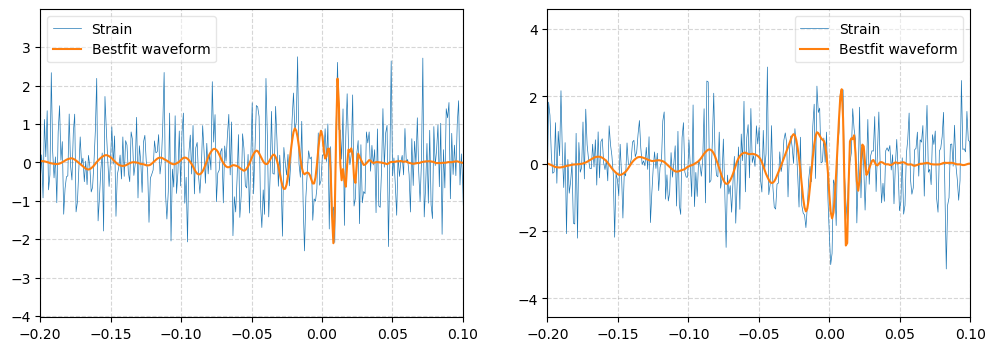

In [53]:
# Checking best-fit waveforms and whitened data comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

trig_obj_H.plot_bestfit_waveform(trig_H, individual_modes=False,
                                 ax=axes[0])
axes[0].set_xlim(left=-0.2,right=0.1); # plt.xlim(left=-2,right=1);
trig_obj_L.plot_bestfit_waveform(trig_L, individual_modes=False,
                                 ax=axes[1])
axes[1].set_xlim(left=-0.2,right=0.1);

In [ ]:
# For checking the mode-by-mode SNR timeseries,
# first get the inputs to the coherent score calculation

import coherent_score_hm_search as cs

dh_mtd, hh_md, times, incoherent_lnprob_td, mode_ratios_qm,\
    tdiff,_, _ = cs.compute_coherent_scores(
    cs_instance, np.array([[trig_H,trig_L]]),
    trig_obj_H, trig_obj_L,
    minimal_time_slide_jump=0.1, return_inputs=True)

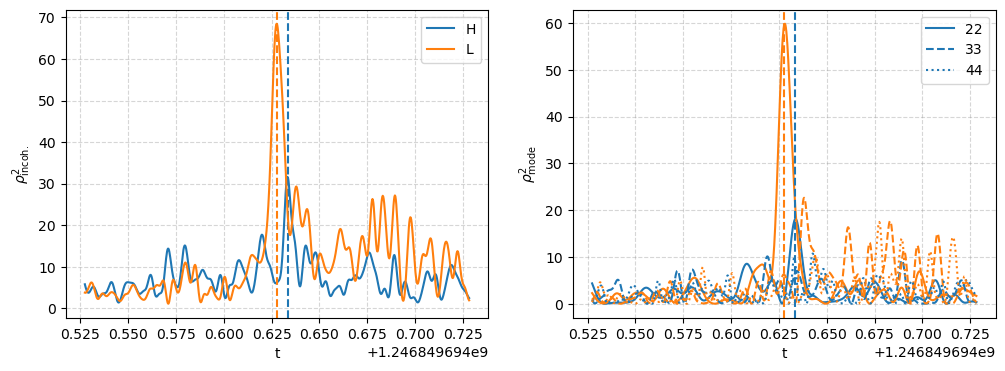

In [55]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(times, 2*incoherent_lnprob_td[:,0], label='H'); plt.axvline(x=trig_H[0], c='C0', ls='--')
plt.plot(times, 2*incoherent_lnprob_td[:,1],label='L'); plt.axvline(x=trig_H[0]+tdiff, c='C1', ls='--')
# plt.axhline(y = np.max(2*incoherent_lnprob_td[:,1])-10)
plt.xlabel('t'); plt.ylabel(r'$\rho^2_\mathrm{incoh.}$'); plt.legend()

plt.subplot(122)
plt.plot(times,np.abs(dh_mtd[0])**2, label=['22',''])
plt.plot(times, (np.abs(dh_mtd[1])**2)[:,0], ls='--', color='C0', label='33')
plt.plot(times, (np.abs(dh_mtd[1])**2)[:,1], ls='--', color='C1')
plt.plot(times, (np.abs(dh_mtd[2])**2)[:,0], ls='dotted', color='C0', label='44')
plt.plot(times, (np.abs(dh_mtd[2])**2)[:,1], ls='dotted', color='C1')
plt.axvline(x=trig_H[0], c='C0', ls='--'); plt.axvline(x=trig_H[0]+tdiff, c='C1', ls='--')
plt.xlabel('t'); plt.ylabel(r'$\rho^2_\mathrm{mode}$')
plt.legend()
# plt.xlim(left=times[350], right=times[480])

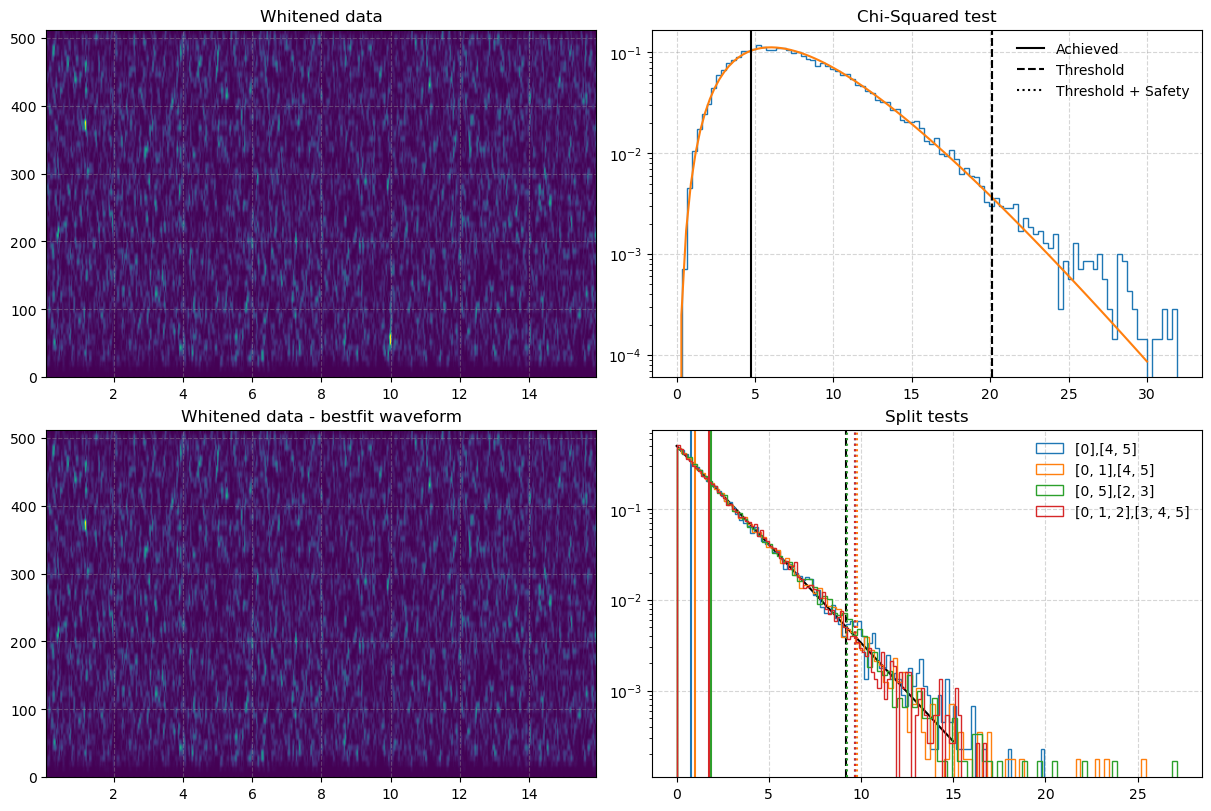

In [56]:
# Extra code for checking thresholds of different veto tests

if len(veto_spacings)==0:
    dcalphas = None
else:
    dcalphas = veto_spacings[0]
utils.plot_veto_details(
    trig_obj_L, trig_L, use_HM=True, dcalphas=dcalphas);

# Plots for paper and saved codes (please ignore)

In [19]:
# Function for changing settings while making plots for paper
# useful as usetex settings are sometimes expensive
import matplotlib as mpl
def mpl_settings(settings):
    if (settings=='default'):
        mpl.rc('text', usetex=False)
        mpl.rcParams['legend.fontsize'] = 'medium'
        plt.rcParams["xtick.labelsize"] = 'medium'
        plt.rcParams["ytick.labelsize"] = 'medium'
        plt.rcParams['axes.labelsize'] = 'medium' 
        plt.rcParams["figure.figsize"] = [5.0, 3.0]
    elif(settings=='paper'):
        mpl.rc('text', usetex=True)
        plt.rcParams["xtick.labelsize"] = 13; plt.rcParams["ytick.labelsize"] = 13
        plt.rcParams['axes.labelsize']=16

In [20]:
mpl_settings('paper')

In [66]:
bkbg.back_0_score=[]; bkbg.back_1_score=[]
bkbg.back_0_score_vetoed=[]; bkbg.back_1_score_vetoed=[]
bkbg.score_funcs =[]
bkbg.rank_scores_calc_old(0, downsampling_correction=True, output_rank_func_temp_grps=False,
                                                  matching_point=27, vetoed=True)

Split the templates into 5 groups for calculating the rank functions.


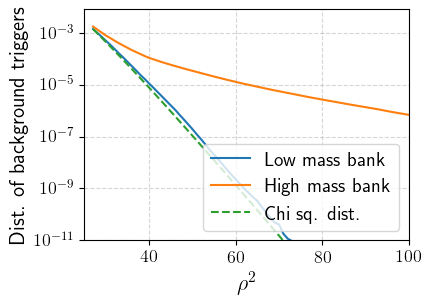

In [107]:
input_arr = np.arange(bkbg.snr2min,300);
low_mass = np.exp(-banksbg[0].score_funcs[0][1](input_arr)/2)
plt.semilogy(input_arr, low_mass,  label='Low mass bank')
plt.semilogy(input_arr, np.exp(-banksbg[14].score_funcs[0][1](input_arr)/2), label='High mass bank')
plt.semilogy(input_arr, (1-stats.chi2.cdf(input_arr,9))/(1-stats.chi2.cdf(input_arr[0],9))*low_mass[0],
             ls='--', label='Chi sq. dist.')
plt.xlabel(r'$\rho^2$'); plt.ylabel('Background trigger rate',size=15); plt.legend(fontsize=14,loc=4)
plt.xlim(left=25,right=100);plt.ylim(bottom=1e-11)
plt.gca().set_aspect(6)
# plt.savefig('/data/jayw/CCA/Plots/trash.pdf', bbox_inches='tight')

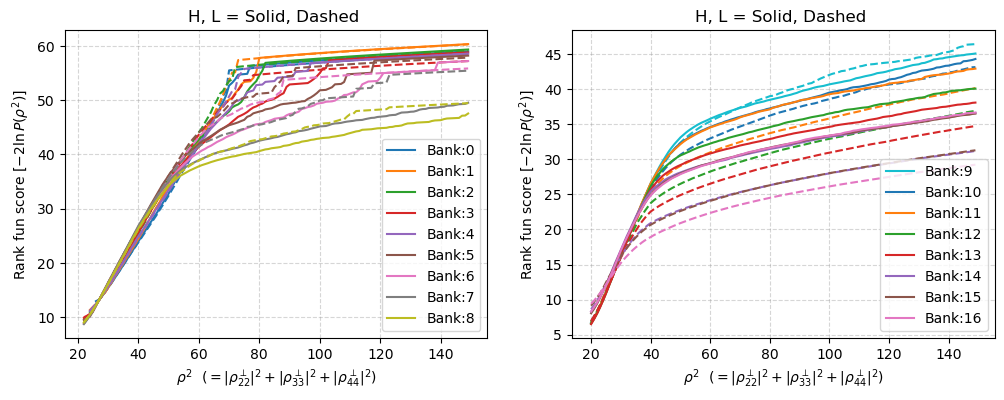

In [ ]:
# O3a
plt.figure(figsize=(12, 4))
plt.subplot(121)
for ib in range(0,9):
    input_arr = np.arange(rank_objs[ib].snr2min,150)
    plt.plot(input_arr, rank_objs[ib].score_funcs[0][0](input_arr), color=f'C{ib}',label=f'Bank:{ib}')
    plt.plot(input_arr, rank_objs[ib].score_funcs[0][1](input_arr), color=f'C{ib}', ls='--')
plt.title('H, L = Solid, Dashed '); plt.legend();
plt.xlabel(r'$\rho^2\ \ (=|\rho^\perp_{22}|^2+|\rho^\perp_{33}|^2+|\rho^\perp_{44}|^2)$');
plt.ylabel(r'Rank fun score [$-2 \ln P(\rho^2)$]');

plt.subplot(122)
for ib in range(9,17):
    input_arr = np.arange(rank_objs[ib].snr2min,150)
    plt.plot(input_arr, rank_objs[ib].score_funcs[0][0](input_arr), color=f'C{ib}',label=f'Bank:{ib}')
    plt.plot(input_arr, rank_objs[ib].score_funcs[0][1](input_arr), color=f'C{ib}', ls='--')
plt.title('H, L = Solid, Dashed '); plt.legend();
plt.xlabel(r'$\rho^2\ \ (=|\rho^\perp_{22}|^2+|\rho^\perp_{33}|^2+|\rho^\perp_{44}|^2)$');
plt.ylabel(r'Rank fun score [$-2 \ln P(\rho^2)$]');

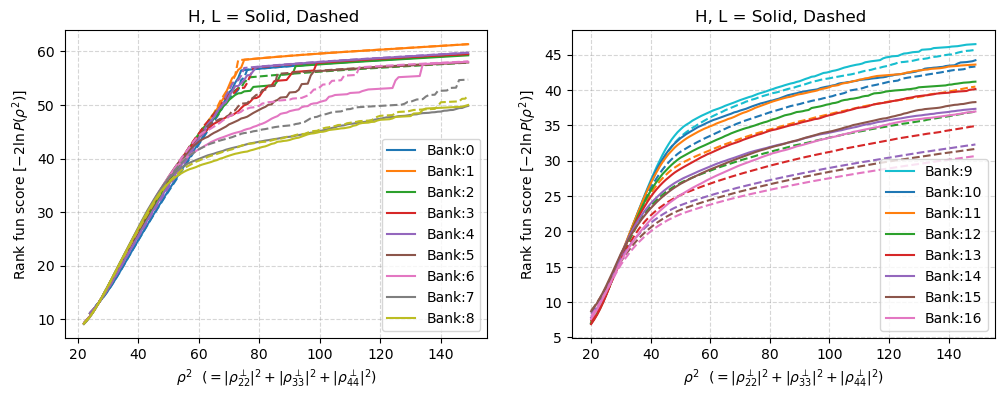

In [ ]:
# O3b
plt.figure(figsize=(12, 4))
plt.subplot(121)
for ib in range(0,9):
    input_arr = np.arange(rank_objs[ib].snr2min,150)
    plt.plot(input_arr, rank_objs[ib].score_funcs[0][0](input_arr), color=f'C{ib}',label=f'Bank:{ib}')
    plt.plot(input_arr, rank_objs[ib].score_funcs[0][1](input_arr), color=f'C{ib}', ls='--')
plt.title('H, L = Solid, Dashed '); plt.legend();
plt.xlabel(r'$\rho^2\ \ (=|\rho^\perp_{22}|^2+|\rho^\perp_{33}|^2+|\rho^\perp_{44}|^2)$');
plt.ylabel(r'Rank fun score [$-2 \ln P(\rho^2)$]');

plt.subplot(122)
for ib in range(9,17):
    input_arr = np.arange(rank_objs[ib].snr2min,150)
    plt.plot(input_arr, rank_objs[ib].score_funcs[0][0](input_arr), color=f'C{ib}',label=f'Bank:{ib}')
    plt.plot(input_arr, rank_objs[ib].score_funcs[0][1](input_arr), color=f'C{ib}', ls='--')
plt.title('H, L = Solid, Dashed '); plt.legend();
plt.xlabel(r'$\rho^2\ \ (=|\rho^\perp_{22}|^2+|\rho^\perp_{33}|^2+|\rho^\perp_{44}|^2)$');
plt.ylabel(r'Rank fun score [$-2 \ln P(\rho^2)$]');

### Checking CS samples

In [ ]:
# This code was sent by Javier to check the extrinsic parameters
# corresponding to the coherent score integral

# use after running section 3.Inspecting interesting candidates

In [ ]:
import pandas as pd
from cogwheel import gw_plotting
def _gen_samples_from_marg_info(self, marg_info, num):  # `self` is a CS
    """
    Generate requested number of extrinsic parameter samples.

    Parameters
    ----------
    marg_info: MarginalizationInfoHM
        Output of ``.get_marginalization_info``.

    num: int, optional
        Number of samples to generate, defaults to a single sample.

    Return
    ------
    samples: dict
        Values are scalar if `num` is ``None``, else numpy arrays.
        If ``marg_info`` correspond to an unphysical sample (i.e.,
        a realization of matched-filtering timeseries in the
        detectors incompatible with a real signal) the values will
        be NaN.
    """
    if marg_info.q_inds.size == 0:
        return dict.fromkeys(['d_luminosity', 'dec', 'lon', 'phi_ref',
                              'psi', 't_geocenter', 'lnl_marginalized',
                              'lnl', 'h_h', 'n_effective', 'n_qmc'],
                             np.full(num, np.nan)[()])

    random_ids = self._rng.choice(len(marg_info.q_inds), size=num,
                                  p=marg_info.weights)

    q_ids = marg_info.q_inds[random_ids]
    o_ids = marg_info.o_inds[random_ids]
    sky_ids = marg_info.sky_inds[random_ids]
    t_geocenter = (marg_info.t_first_det[random_ids]
                   - self.sky_dict.geocenter_delay_first_det[sky_ids])
    d_h = marg_info.d_h[random_ids]
    h_h = marg_info.h_h[random_ids]

    d_luminosity = self._sample_distance(d_h, h_h)
    distance_ratio = d_luminosity / self.lookup_table.REFERENCE_DISTANCE
    return {
        'd_luminosity': d_luminosity,
        'dec': self.sky_dict.sky_samples['lat'][sky_ids],
        'lon': self.sky_dict.sky_samples['lon'][sky_ids],
        'phi_ref': self._phi_ref[o_ids],
        'psi': self._qmc_sequence['psi'][q_ids],
        't_geocenter': t_geocenter,
        'lnl_marginalized': np.full(num, marg_info.lnl_marginalized)[()],
        'lnl': d_h / distance_ratio - h_h / distance_ratio**2 / 2,
        'h_h': h_h / distance_ratio**2,
        'n_effective': np.full(num, marg_info.n_effective)[()],
        'n_qmc': np.full(num, marg_info.n_qmc)[()],
        'cosiota': self._qmc_sequence['cosiota'][q_ids],
        }

samples_list = []
for i in range(10):
    marg_info = cs_instance.get_marginalization_info(dh_mtd, hh_md,
                            times, incoherent_lnprob_td, mode_ratios_qm)
    samples_list.append(pd.DataFrame(_gen_samples_from_marg_info(cs_instance, marg_info, 1000)))
samples = pd.concat(samples_list)
samples = pd.DataFrame(samples)

In [ ]:
params_samples = ['dec', 'lon',
 'd_luminosity',
 'psi',
 # 't_H',
 # 't_L',         
 'lnl_marginalized',
 'lnl',
 # 'h_h',
 'n_effective',
 'cosiota']

/data/jayw/IAS/GW/cogwheel/cogwheel/plotting.py:457: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.imshow(pdf, origin='lower', aspect='auto', extent=extent,
/data/jayw/IAS/GW/cogwheel/cogwheel/plotting.py:457: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.imshow(pdf, origin='lower', aspect='auto', extent=extent,


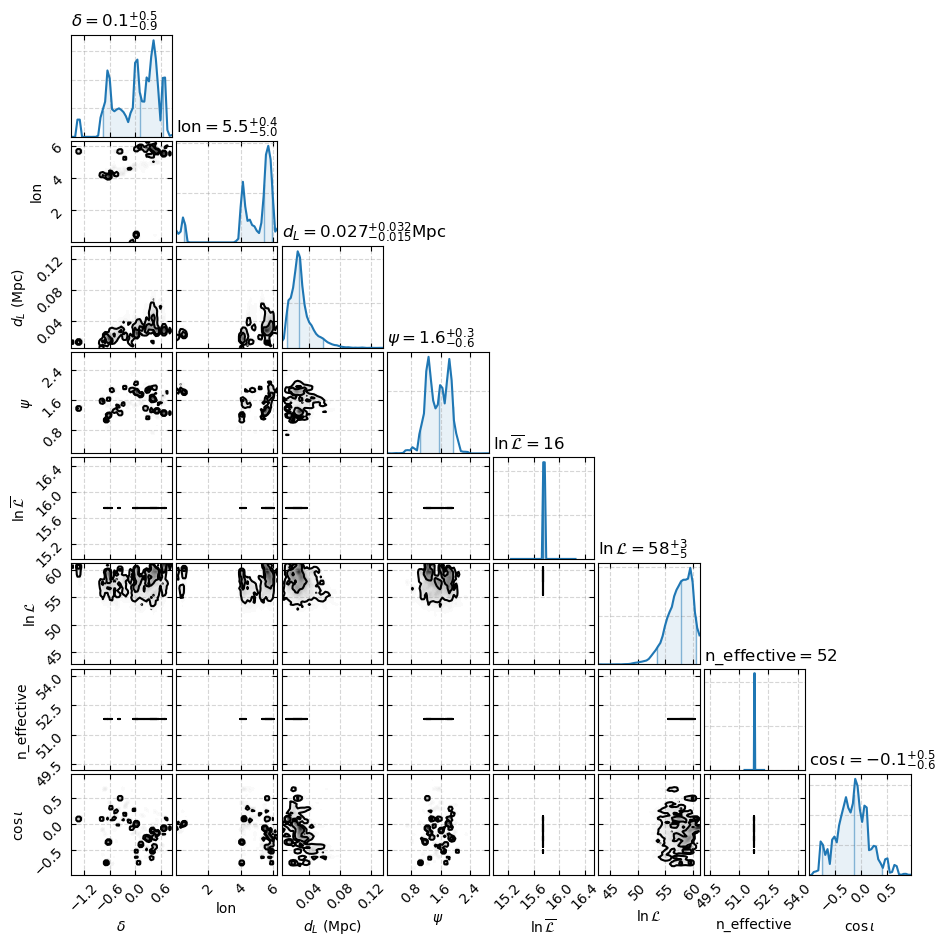

In [ ]:
cp = gw_plotting.CornerPlot(samples[params_samples])
cp.plot()

### Using a few files to estimate the rank func correction at low SNR

In [ ]:
# Ignore this cell for now

# I will upload a separate code for calculating downsampling corrections
# but just use the following data for now
# or set downsampling_correction=False below
# downsamp_corr_path = '/data/jayw/IAS/GW/Data/HM_O3a_search/Ranking/Downsampling_corrections/'
# downsamp_corr_path = os.path.join(downsamp_corr_path,f'BBH_{i}.npy')
# downsamp_corr_path used for O3b is the same as O3a

In [ ]:
# This section needs cleaning and is not yet ready

In [ ]:
banksbg_down = []
dire = '/data/jayw/IAS/GW/Data/HM_O3a_search/OutputDir/For_Rank_fn_correction/'
for i in range(0,17):
    fake_cand_dirs = [[[]]*17]
    fake_output_dirs = [[[]]*17]
    fake_cand_dirs[0][i] = [dire+f'BBH_{i}_bank_{j}cand0' for j in range(tbp.nsubbanks[f'BBH_{i}'])]
    fake_output_dirs[0][i] = [dire+f'BBH_{i}_bank_{j}' for j in range(tbp.nsubbanks[f'BBH_{i}'])]
    banksbg_down.append(rank.Rank(chirp_mass_id=i, cver='cand0', runs=[run], collect_before_veto=True, 
                               collect_timeseries=False,
            coinc_ftype='npz', cs_ver='JR', cand_dirs_all=fake_cand_dirs, outputdirs_all=fake_output_dirs))

In [ ]:
rank.maximize_over_banks(banksbg_down, fmt='O3a', template_prior_applied=False)

In [ ]:
banksbg = []
dire = '/data/jayw/IAS/GW/Data/HM_O3a_search/OutputDir/For_Rank_fn_correction/Comparison_unsampled/'
for i in range(0,17):
    fake_cand_dirs = [[[]]*17]
    fake_output_dirs = [[[]]*17]
    fake_cand_dirs[0][i] = [dire+f'BBH_{i}_bank_{j}cand0' for j in range(tbp.nsubbanks[f'BBH_{i}'])]
    fake_output_dirs[0][i] = [dire+f'BBH_{i}_bank_{j}' for j in range(tbp.nsubbanks[f'BBH_{i}'])]
    banksbg.append(rank.Rank(chirp_mass_id=i, cver='cand0', runs=[run], collect_before_veto=True, 
                               collect_timeseries=False,
            coinc_ftype='npz', cs_ver='JR', cand_dirs_all=fake_cand_dirs, outputdirs_all=fake_output_dirs))

In [ ]:
rank.maximize_over_banks(banksbg, fmt='O3a', template_prior_applied=False)

In [ ]:
len(banksbg[1].scores_bg_by_subbank[2])

276

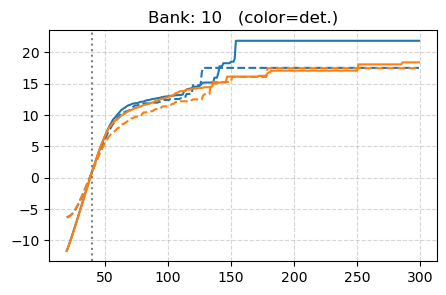

In [ ]:
ib=10; isb=0
input_arr = np.arange(banksbg_down[ib].snr2min, 300)
ind = np.argmin(np.abs(input_arr - 2*banksbg_down[ib].snr2min))
for det in range(2):
    diff = (banksbg_down[ib].score_funcs[isb][det](input_arr) - banksbg[ib].score_funcs[isb][det](input_arr))[ind]
    plt.plot(input_arr, banksbg_down[ib].score_funcs[isb][det](input_arr), color=f'C{det}')
    plt.plot(input_arr, banksbg[ib].score_funcs[isb][det](input_arr)+diff, color=f'C{det}', ls='--')
plt.axvline(x = 2*banksbg_down[ib].snr2min,color='gray', ls='dotted')
plt.title(f'Bank: {ib}   (color=det.)');

In [ ]:
# NOTE: BBH-1,2 corrections are nan as they not sampled enough, use BBH-1,1 for that subbank for
# the time being

In [ ]:
# # Uncomment for updating the Downsampling_corrections npy files
# for ib in range(0,17):
#     downsampling_corrections=[]
#     for isb in range(tbp.nsubbanks[f'BBH_{ib}']):
#         input_arr = np.arange(banksbg_down[ib].snr2min, 2* banksbg_down[ib].snr2min,0.1)
#         diff_H = banksbg_down[ib].score_funcs[isb][0](input_arr) - banksbg[ib].score_funcs[isb][0](input_arr)
#         diff_H = diff_H - diff_H[-1]
#         diff_L = banksbg_down[ib].score_funcs[isb][1](input_arr) - banksbg[ib].score_funcs[isb][1](input_arr)
#         diff_L = diff_L - diff_L[-1]
#         downsampling_corrections.append(np.c_[input_arr, diff_H, diff_L])
#     np.save(f'/data/jayw/IAS/GW/Data/HM_O3a_search/BanksBG/Downsampling_corrections/BBH_{ib}.npy',
#             np.array(downsampling_corrections))

In [ ]:
a = np.load(f'/data/jayw/IAS/GW/Data/HM_{run}_search/BanksBG/Downsampling_corrections/BBH_{1}.npy')[2]

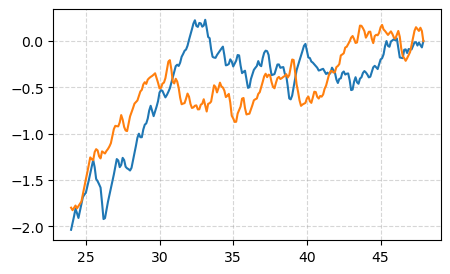

In [ ]:
plt.plot(a[:,0],a[:,1])
plt.plot(a[:,0],a[:,2])

# Debugging (please ignore)

In [ ]:
# Please ignore this section

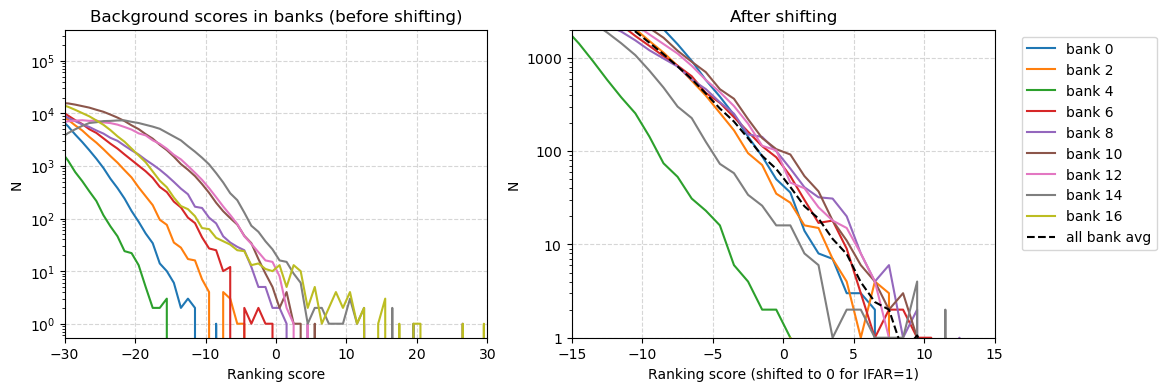

In [251]:
LOWER_lim, UPPER_lim= (-100, 45)
bins=np.arange(LOWER_lim, UPPER_lim,1)
bincenters = (bins[1:]+bins[:-1])/2
plt.figure(figsize=(12,4))
plt.subplot(121)
for ib in range(0,17,2):
    val, *_ = np.histogram(rank_objs[ib].rank_scores_bg[rank_objs[ib].rank_scores_bg>LOWER_lim],bins=bins);
    plt.semilogy(bincenters,val,label=f'bank {ib}')
    plt.title('Background scores in banks (before shifting)');
plt.xlim(left=-30, right=30)
plt.xlabel('Ranking score'); plt.ylabel('N'); 
plt.subplot(122)
for ib in range(0,17,2):
    val, *_ = np.histogram(rank_objs[ib].rank_scores_bg_shifted[rank_objs[ib].rank_scores_bg_shifted>LOWER_lim],bins=bins);
    plt.semilogy(bincenters,val,label=f'bank {ib}')
val, *_ = np.histogram(allbanksbg_shifted[allbanksbg_shifted>LOWER_lim],bins=bins);
plt.semilogy(bincenters,val/17,color='k',ls='--', label='all bank avg')
plt.xlim(left=-15, right=15)
plt.ylim(top=2e3,bottom=1e0); 
plt.legend(loc=1,bbox_to_anchor=(1.4, 1.0))
plt.xlabel('Ranking score (shifted to 0 for IFAR=1)'); plt.ylabel('N'); 
plt.title('After shifting');

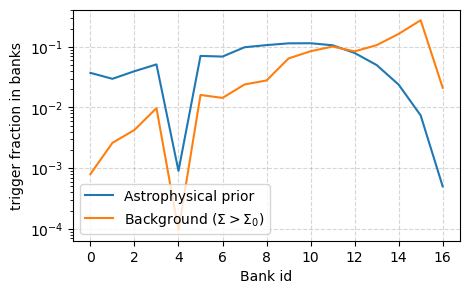

In [256]:
n_bkg = np.array([np.count_nonzero(rank_objs[ib].rank_scores_bg>-20) for ib in range(17)])
plt.semilogy(weights_banks, label='Astrophysical prior')
plt.semilogy(n_bkg/np.sum(n_bkg), label=r'Background ($\Sigma>\Sigma_0$)')
plt.xlabel('Bank id'); plt.ylabel('trigger fraction in banks'); 
plt.legend();

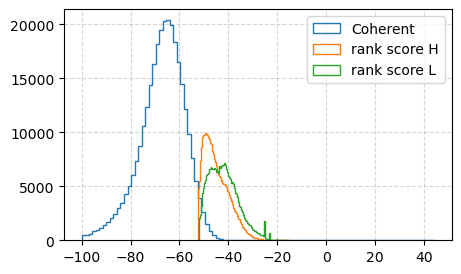

In [ ]:
ib=16
plt.hist(rank_objs[ib].coherent_scores_bg[rank_objs[ib].coherent_scores_bg>-100],bins=100, histtype='step',label='Coherent');
plt.hist(rank_objs[ib].back_0_score-60, bins=100, histtype='step', label='rank score H');
plt.hist(rank_objs[ib].back_1_score-60, bins=100, histtype='step', label='rank score L');
plt.legend()

In [ ]:
temp_prior_14 = np.array([evn[0][-1] for evn in rank_objs[14].scores_vetoed_max[0]])/2/2.303
temp_prior_14 = temp_prior_14[rank_objs[14].rank_scores_bg>-30]
temp_prior_3 = np.array([evn[0][-1] for evn in rank_objs[3].scores_vetoed_max[0]])/2/2.303
temp_prior_3 = temp_prior_3[rank_objs[3].rank_scores_bg>-30]

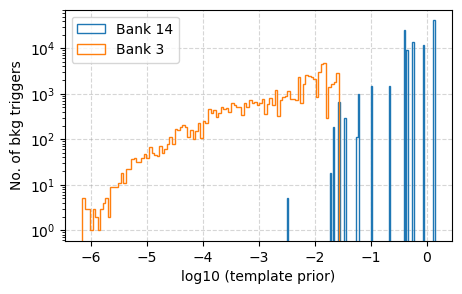

In [ ]:
plt.hist(temp_prior_14, histtype='step', bins=100, label='Bank 14',log=True);
plt.hist(temp_prior_3, histtype='step', bins=100, label='Bank 3',log=True);
plt.xlabel('log10 (template prior)'); plt.ylabel(r'No. of bkg triggers');
plt.legend();

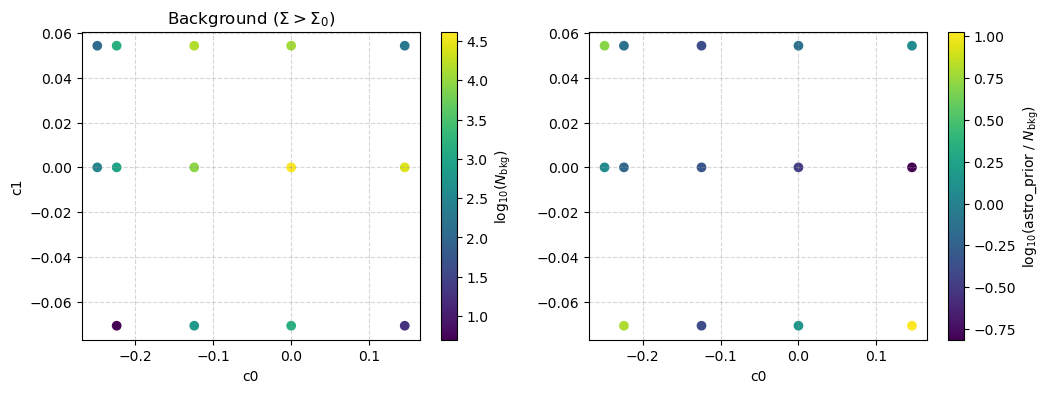

In [ ]:
ib=14; isb=0
trig_templates = np.array([evn[1][0,-2:] for evn in rank_objs[ib].scores_vetoed_max[0]])
mask = np.array([evn[2][1]==isb for evn in rank_objs[ib].scores_vetoed_max[0]])
mask *= rank_objs[ib].rank_scores_bg>-30
trig_templates = trig_templates[mask]
unique_templates, count = np.unique(trig_templates, axis=0, return_counts=True)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(unique_templates[:,0], unique_templates[:,1], c=np.log10(count), cmap='viridis')
plt.colorbar(label=r'log$_{10}(N_\mathrm{bkg}$)')
plt.xlabel('c0'); plt.ylabel('c1');
plt.title(r'Background ($\Sigma>\Sigma_0$)')
plt.subplot(122)
astro_prior = (rank_objs[ib].example_trigs[isb].templatebank.Template_Prior_NF.log_prior(unique_templates))/2.303
logcount_diff = astro_prior-np.log10(count)+4
# vmin = max(max(astro_prior)-4, min(astro_prior))
plt.scatter(unique_templates[:,0], unique_templates[:,1], 
            c=logcount_diff, cmap='viridis')
plt.colorbar(label=r'log$_{10}$(astro_prior / $N_\mathrm{bkg}$)')
plt.xlabel('c0');

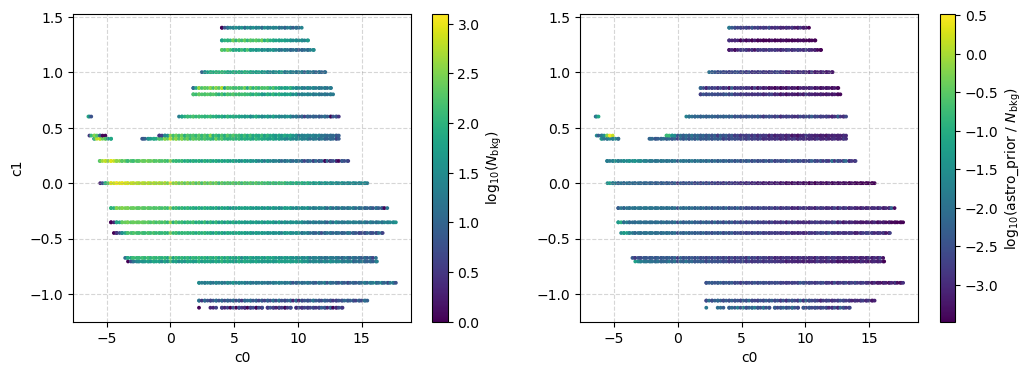

In [ ]:
ib=3; isb=0
point_size = 3
trig_templates = np.array([evn[1][0,-2:] for evn in rank_objs[ib].scores_vetoed_max[0]])
mask = np.array([evn[2][1]==isb for evn in rank_objs[ib].scores_vetoed_max[0]])
mask *= rank_objs[ib].rank_scores_bg>-40
trig_templates = trig_templates[mask]
unique_templates, count = np.unique(trig_templates, axis=0, return_counts=True)
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.scatter(unique_templates[:,0], unique_templates[:,1], c=np.log10(count), cmap='viridis',s=point_size)
plt.colorbar(label=r'log$_{10}(N_\mathrm{bkg}$)')
plt.xlabel('c0'); plt.ylabel('c1');
plt.subplot(122)
astro_prior = (rank_objs[ib].example_trigs[isb].templatebank.Template_Prior_NF.log_prior(unique_templates))/2.303
logcount_diff = astro_prior-np.log10(count)+4
vmin = max(max(logcount_diff)-4, min(logcount_diff))
plt.scatter(unique_templates[:,0], unique_templates[:,1], 
            c=logcount_diff, cmap='viridis', s=point_size, vmin=vmin)
plt.colorbar(label=r'log$_{10}$(astro_prior / $N_\mathrm{bkg}$)')
plt.xlabel('c0');